In [1]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 5.2 MB/s 


# Assignment 1

## De Francesco Matteo

In this assignment we are goint to train a denoising autoencoder over the MNIST dataset.    
We will perform 2 different kinds of training:
- We train each autoencoder as a single block changing the input dimension and the latent dimension. Starting from the original input image size (28*28), we train the following autoencoders: 
    - 784 -> 400 -> 784
    - 400 -> 200 -> 400
- Finetuning: finally, assemble together the different weights trained previously on the single autoencoders and perform finetuning over the entire model.

We can represent the flow of each autoencoder in the following way

\begin{align*}
  x → ϵ \sim \mathcal{N}(0,1) → \hat{x} = x + ϵ \\
  \hat{x} → z = E(\hat{x}) → \tilde{x} = D(z) \\
  loss = L(x, D(E(\hat{x})))
\end{align*}

## IMPORTANT:

(Optional) Remove the cell below to don't connet to drive and change basepath to the empty string to test everything locally.    
Otherwise leave the connection to the drive and change the basepath to point to the according folder in your Drive.    
Change also the number of epochs later to make testing faster

In [2]:
from google.colab import drive

drive.mount("/content/mydrive")

Mounted at /content/mydrive


In [3]:
basepath = "/content/mydrive/MyDrive/LEZIONI AA 2020 21/ISPR/assignments/assignment3"

## Imports

We import the required libraries

In [4]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import time
import torch.nn.functional as F
import pickle as pkl
import pickle5 as pickle

from tqdm import tqdm
from matplotlib.gridspec import SubplotSpec
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

plt.style.use('ggplot')

Utility functions to extract images and labels from MNIST dataset

In [5]:
def training_images(basepath):
    with gzip.open(os.path.join(basepath, 'data/train-images-idx3-ubyte.gz'), 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels(basepath):
    with gzip.open(os.path.join(basepath, 'data/train-labels-idx1-ubyte.gz'), 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

def testing_images(basepath):
    with gzip.open(os.path.join(basepath, 'data/t10k-images-idx3-ubyte.gz'), 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def testing_labels(basepath):
    with gzip.open(os.path.join(basepath, 'data/t10k-labels-idx1-ubyte.gz'), 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [6]:
if not os.path.exists(os.path.join(basepath, f"weights2")):
    os.makedirs(os.path.join(basepath, f"weights2"))

if not os.path.exists(os.path.join(basepath, f"results2")):
    os.makedirs(os.path.join(basepath, f"results2"))


Extract the images and the labels

In [7]:
tr_images = training_images(basepath)
tr_labels = training_labels(basepath)

ts_images = testing_images(basepath)
ts_labels = testing_labels(basepath)

Normalize each image in the range [0,1] before going on

In [8]:
## Normalize each image before: the minimum is basically 0 while the maximum is 255
tr_images = tr_images / 255
ts_images = ts_images / 255

9


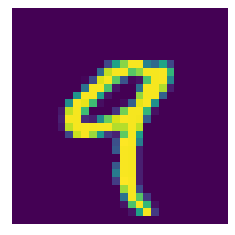

In [9]:
plt.imshow((tr_images[4]*255).astype(np.uint8), cmap=plt.cm.viridis)

plt.xticks([])
plt.yticks([])

print(tr_labels[4])

## Datasets

Let's set up our data loader both for training and testing. First of all we create the required tensors

In [10]:
noisy_tr_images = torch.tensor([image.astype(float) for image in tr_images]).float()
tr_images = torch.tensor([image.astype(float) for image in tr_images]).float()
tr_labels = torch.tensor([label for label in tr_labels])

noisy_ts_images = torch.tensor([image.astype(float) for image in ts_images]).float()
ts_images = torch.tensor([image.astype(float) for image in ts_images]).float()
ts_labels = torch.tensor([label for label in ts_labels])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """Entry point for launching an IPython kernel.


Perturb each tensor image with a sample Gaussian noise from $\mathcal{N}(0,1)$ and clamp the resulting noisy tensors to make data lie in the normalized range

In [11]:
mean = 0.
std = 0.1

for i in range(len(noisy_tr_images)):
  sample = torch.randn(noisy_tr_images[i].size()) * std + mean
  noisy_tr_images[i] = noisy_tr_images[i] + sample
  # Clamp the image: since we want our data to lie in the range [0,1] we clamp the resulting noise addition
  # noisy_tr_images[i] = torch.clamp(noisy_tr_images[i], 0., 1.)

for i in range(len(noisy_ts_images)):
  sample = torch.randn(noisy_ts_images[i].size()) * std + mean
  noisy_ts_images[i] = noisy_ts_images[i] + sample
  # noisy_ts_images[i] = torch.clamp(noisy_ts_images[i], 0., 1.)

Let's show an image perturbed with noise and normalized. We turn back the type to uint8 to have an effective visualization

tensor(9, dtype=torch.uint8)


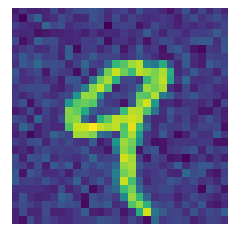

In [12]:
plt.imshow((noisy_tr_images[4]*255), cmap=plt.cm.viridis)

plt.xticks([])
plt.yticks([])

print(tr_labels[4])

In [13]:
# Create a copy of the images
tr_images_copy = tr_images.clone()
noisy_tr_images_copy = noisy_tr_images.clone()
ts_images_copy = ts_images.clone()
noisy_ts_images_copy = noisy_ts_images.clone()

In [14]:
# Create dataset
train_dataset = TensorDataset( tr_images, noisy_tr_images, tr_labels )
test_dataset = TensorDataset( ts_images, noisy_ts_images, ts_labels )

## Autoencoder

In the following, we create a single-layer denoising autoencoder to perform training over the MNIST dataset

In [15]:
class DAE(nn.Module):

  '''
    Simple DAE with a single hidden layer. 
    We initialize a set of nn.Parameter with random weights created with the he_init formula to train our model.
    The set of weights and the methods to perform flow through the model are initialized with the low level API in order
    to use this same set of weights also in the decoder part.
  '''
  def __init__(self, input_dim, latent_dim, option, batch_size):
    super().__init__()
    self.option = option  
    self.batch_size = batch_size

    # Create weights with the he_init initialization
    w = torch.empty(latent_dim, input_dim) 
    w = w.normal_(0, np.sqrt( 2. / latent_dim ))

    # Create set of Parameters
    self.weights = nn.Parameter( w )

    # Flattening module to make input 1-dimensional
    self.flattening = nn.Flatten()

  '''
    Perform latent space interpolation with two given input images. Create a convex combination
    of the encoded images with a given parameter \alpha \in [0,1] and reconstruct the resulting images
  '''
  def latent_space_interpolation(self, input_1, input_2, alpha):
    assert(0 <= alpha <= 1)

    x_1 = self.flattening(input_1)
    x_2 = self.flattening(input_2)

    # Creation z_1
    z_1 = F.relu_( F.linear(x_1, self.weights) )

    # Creation z_2
    z_2 = F.relu_( F.linear(x_2, self.weights) )

    # Create convex combination of z_1 and z_2
    z = alpha * z_1 + (1 - alpha) * z_2

    reconstruction = torch.sigmoid( F.linear(z, self.weights.T) )
    reconstruction = torch.reshape(reconstruction, input_1.shape)

    return reconstruction, z

  '''
    Forward method: make data flow through the net, by flattening the input, apply the encoding, and the decoding section.
    We distinguish the output layer of the decoder from the hidden ones with the option member, putting a sigmoid activation
    for the last layer and a relu instead in the other decoding parts
  '''
  def forward(self, input):
    x = self.flattening(input)
    # Latent representation
    z = F.relu_( F.linear(x, self.weights) )

    if self.option == "output":
      reconstruction = torch.sigmoid( F.linear(z, self.weights.T) )
    else:
      reconstruction = F.relu_( F.linear(z, self.weights.T) )

    reconstruction = torch.reshape(reconstruction, input.shape)

    return reconstruction, z

  '''
    Compute the MSE loss function between the original image and the reconstructed image
  '''
  def loss(self, original_image, reconstruction):
    # The loss is the MSE between the reconstruction over the noisy image and the original image
    loss = F.mse_loss(original_image, reconstruction)
    return loss

Utility functions to fit the model, by performing training and validation

In [16]:
def fit_model(EPOCHS, DEVICE, train_loader, valid_loader, model, optimizer, decay, INPUT_SIZE, LATENT_DIM):

  validation_steps = 0
  best_model = None

  max_valid_loss = np.inf
  train_loss, valid_loss = [], []

  train_epoch_loss, valid_epoch_loss = [], []
  train_dict, valid_dict = {}, {}

  for epoch in range(EPOCHS):

    print("Epoch : {}/{}".format(epoch+1, EPOCHS))

    # Perform training and validation
    start = time.time()
    train_ae(DEVICE, train_loader, model, optimizer, train_loss, train_epoch_loss)
    valid_ae(DEVICE, valid_loader, model, valid_loss, valid_epoch_loss, INPUT_SIZE, LATENT_DIM, EPOCHS)
    end = time.time()

    # Save the actual training loss and validation loss
    train_dict[epoch+1] = np.mean(train_epoch_loss)
    valid_dict[epoch+1] = np.mean(valid_epoch_loss)

    print("Time elapsed: {}".format(end-start))

    # Early stopping criterion based on last validation loss
    if valid_dict[epoch+1] < max_valid_loss:
      print("Reset validation steps")
      validation_steps = 0
      max_valid_loss = valid_dict[epoch+1]
    else:
      print("Increasing validation steps")
      validation_steps += 1
      if validation_steps == 10:
        print("Maximum validaton epochs reached")
        # Early stopping heuristics
        return model, train_loss, valid_loss, train_epoch_loss, valid_epoch_loss

  # Save loss results to pickle object
  with open(os.path.join(basepath, f'results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/train.pickle'), 'wb') as handle:
    pkl.dump(train_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

  with open(os.path.join(basepath, f'results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/valid.pickle'), 'wb') as handle:
    pkl.dump(valid_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

  return model, train_loss, valid_loss, train_epoch_loss, valid_epoch_loss


# Training
def train_ae(DEVICE, train_loader, model, optimizer, train_loss, train_epoch_loss):
  # set model in training mode
  model.train()

  print("Training")

  total_loss = []

  for original_img, noisy_img, label in tqdm(train_loader):
    optimizer.zero_grad()

    noisy_img = noisy_img.to(DEVICE)
    original_img = original_img.to(DEVICE)
    label = label.to(DEVICE)

    output, z = model(noisy_img)

    loss = model.loss(original_img.flatten(), output.flatten())

    train_loss.append(loss.item())
    total_loss.append(loss.item())

    loss.backward()

    optimizer.step()
  
  print(f"Mean training loss: {np.mean(train_loss)}")
  train_epoch_loss.append(np.mean(total_loss))


# Validation
def valid_ae(DEVICE, valid_loader, model, valid_loss, valid_epoch_loss, INPUT_SIZE, LATENT_DIM, EPOCHS):
    
  model.eval()

  print("Validation")

  total_loss = []

  with torch.no_grad():
    for original_img, noisy_img, label in tqdm(valid_loader):
      noisy_img = noisy_img.to(DEVICE)

      original_img = original_img.to(DEVICE)
      # print(img)
      label = label.to(DEVICE)

      output, z = model(noisy_img)

      loss = model.loss(original_img, output)

      valid_loss.append(loss.item())
      total_loss.append(loss.item())

  # Save last images to visualize them
  torch.save(output, os.path.join(basepath, f'results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/outputs.pt'))
  torch.save(original_img, os.path.join(basepath, f'results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/original.pt'))
  torch.save(noisy_img, os.path.join(basepath, f'results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/noisy.pt'))

  print(f"Mean validation loss: {np.mean(valid_loss)}")
  valid_epoch_loss.append(np.mean(total_loss))

## Layerwise pretraining

In this section we are going to pretrain layerwise our model. We reuse the same code as before being defining a __DAE__ changing the input and output size accordingly.

Fixed a set of latent dimension, we execute for each autoencoder a certain number of training epochs and we store the trained weights: this will be used later all together to assemble our deep autoencoder.

We use a support function below to update the dataset by modifying the original images and the noisy images passing them through the last trained layer.

In [17]:
def create_new_dataset(tr_images, noisy_tr_images, ts_images, noisy_ts_images, tr_labels, ts_labels, model, DEVICE):
    
  print("Creating set of data for the next layer")
  new_noisy_images = []
  new_original_images = []

  new_noisy_ts_images = []
  new_original_ts_images = []

  with torch.no_grad():

    # Pass all the training images and store the encoding
    for original_tr_img, noisy_tr_img in zip(tr_images, noisy_tr_images):

      original_tr_img, noisy_tr_img = original_tr_img.to(DEVICE), noisy_tr_img.to(DEVICE)

      _, noisy_z = model(torch.reshape(noisy_tr_img, (1, ) + noisy_tr_img.shape))
      _, original_z = model(torch.reshape(original_tr_img, (1, ) + original_tr_img.shape))

      new_noisy_images.append(noisy_z)
      new_original_images.append(original_z)

    # Pass all the validation images and store the encoding
    for original_ts_img, noisy_ts_img in zip(ts_images, noisy_ts_images):

      original_ts_img, noisy_ts_img = original_ts_img.to(DEVICE), noisy_ts_img.to(DEVICE)

      _, noisy_z = model(torch.reshape(noisy_ts_img, (1, ) + noisy_ts_img.shape))
      _, original_z = model(torch.reshape(original_ts_img, (1, ) + original_ts_img.shape))

      new_noisy_ts_images.append(noisy_z)
      new_original_ts_images.append(original_z)

  # Create new images and noisy images
  tr_images = torch.stack((new_original_images))
  noisy_tr_images = torch.stack((new_noisy_images))
  ts_images = torch.stack((new_original_ts_images))
  noisy_ts_images = torch.stack((new_noisy_ts_images))

  # Create new dataset
  train_dataset = TensorDataset( tr_images, noisy_tr_images, tr_labels )
  test_dataset = TensorDataset( ts_images, noisy_ts_images, ts_labels )

  return train_dataset, test_dataset, tr_images, noisy_tr_images, ts_images, noisy_ts_images

Now we can loop through each autoencoder to make a single training of them

In [ ]:
for i, latent_dim in enumerate([400, 200]):

  BATCH_SIZE = 32

  # If we are training the first latent dimension, we set the option to output
  if i == 0:
    INPUT_SIZE = tr_images[0].shape[0]*tr_images[0].shape[0]
    opion = "output"
  else:
    INPUT_SIZE = tr_images[0].shape[1]
    option = "hidden"

  print(INPUT_SIZE)

  LATENT_DIM = latent_dim

  EPOCHS = 50

  LR = 0.1

  DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Instantiate a single DAE to pretrain this level
  model = DAE(INPUT_SIZE, LATENT_DIM, "pretrain", BATCH_SIZE)

  model.to(DEVICE)

  optim = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.)

  # Sample randomly from the training dataset and create the DataLoader
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

  # Sample sequentially from the validation dataset to assess the generalization
  valid_sampler = SequentialSampler(test_dataset)
  valid_dataloader = DataLoader(test_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

  # Create folder to store the results and weigths
  if not os.path.exists(os.path.join(basepath, f"weights2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}")):
    os.makedirs(os.path.join(basepath, f"weights2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}"))

  if not os.path.exists(os.path.join(basepath, f"results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}")):
    os.makedirs(os.path.join(basepath, f"results2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}"))

  # Fit the model
  model, train_loss, valid_loss, train_epoch_loss, valid_epoch_loss = fit_model(EPOCHS, DEVICE, train_dataloader, valid_dataloader, model, optim, None, INPUT_SIZE, LATENT_DIM)

  # Save current weights
  torch.save(model.state_dict(), os.path.join(basepath, f'weights2/in{INPUT_SIZE}_out{LATENT_DIM}_epochs{EPOCHS}/model_weights.pth'))

  # Update dataset
  train_dataset, test_dataset, tr_images, noisy_tr_images, ts_images, noisy_ts_images = create_new_dataset(tr_images, noisy_tr_images, ts_images, noisy_ts_images, tr_labels, ts_labels, model, DEVICE)

# Keep track of the epochs used in the training phase
OLD_EPOCHS = EPOCHS

784
Epoch : 1/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 645.72it/s]


Mean training loss: 0.05230172030429046
Validation


100%|██████████| 313/313 [00:00<00:00, 1249.62it/s]


Mean validation loss: 0.03625315852677479
Time elapsed: 3.1900486946105957
Reset validation steps
Epoch : 2/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 646.60it/s]


Mean training loss: 0.042198234520355864
Validation


100%|██████████| 313/313 [00:00<00:00, 1223.69it/s]


Mean validation loss: 0.03240778105863081
Time elapsed: 3.1891427040100098
Reset validation steps
Epoch : 3/50
Training


100%|██████████| 1875/1875 [00:04<00:00, 406.04it/s]


Mean training loss: 0.03703168070481883
Validation


100%|██████████| 313/313 [00:00<00:00, 750.30it/s]


Mean validation loss: 0.02984999803205331
Time elapsed: 5.069389820098877
Reset validation steps
Epoch : 4/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 657.86it/s]


Mean training loss: 0.03368301505347093
Validation


100%|██████████| 313/313 [00:00<00:00, 1260.36it/s]


Mean validation loss: 0.02795907297876839
Time elapsed: 3.133950710296631
Reset validation steps
Epoch : 5/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 630.28it/s]


Mean training loss: 0.031256032143831255
Validation


100%|██████████| 313/313 [00:00<00:00, 1007.52it/s]


Mean validation loss: 0.026471154048396187
Time elapsed: 3.3360958099365234
Reset validation steps
Epoch : 6/50
Training


100%|██████████| 1875/1875 [00:04<00:00, 451.70it/s]


Mean training loss: 0.029377221813135675
Validation


100%|██████████| 313/313 [00:00<00:00, 925.26it/s]


Mean validation loss: 0.025251756394450594
Time elapsed: 4.524247407913208
Reset validation steps
Epoch : 7/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 563.69it/s]


Mean training loss: 0.027858725435818944
Validation


100%|██████████| 313/313 [00:00<00:00, 1215.11it/s]


Mean validation loss: 0.024223496982702812
Time elapsed: 3.6183955669403076
Reset validation steps
Epoch : 8/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 604.45it/s]


Mean training loss: 0.0265935765651986
Validation


100%|██████████| 313/313 [00:00<00:00, 777.77it/s]


Mean validation loss: 0.023338618491160364
Time elapsed: 3.5579874515533447
Reset validation steps
Epoch : 9/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 599.90it/s]


Mean training loss: 0.02551537415009958
Validation


100%|██████████| 313/313 [00:00<00:00, 1238.80it/s]


Mean validation loss: 0.022564657496993937
Time elapsed: 3.4137167930603027
Reset validation steps
Epoch : 10/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 607.64it/s]


Mean training loss: 0.02458034498964747
Validation


100%|██████████| 313/313 [00:00<00:00, 825.11it/s]


Mean validation loss: 0.021878879496786064
Time elapsed: 3.5098824501037598
Reset validation steps
Epoch : 11/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 590.69it/s]


Mean training loss: 0.02375817873983672
Validation


100%|██████████| 313/313 [00:00<00:00, 947.24it/s]


Mean validation loss: 0.021265166491917096
Time elapsed: 3.554267168045044
Reset validation steps
Epoch : 12/50
Training


100%|██████████| 1875/1875 [00:04<00:00, 398.70it/s]


Mean training loss: 0.023027043444870245
Validation


100%|██████████| 313/313 [00:00<00:00, 640.46it/s]


Mean validation loss: 0.02071124075339657
Time elapsed: 5.238712787628174
Reset validation steps
Epoch : 13/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 655.46it/s]


Mean training loss: 0.022370715112487474
Validation


100%|██████████| 313/313 [00:00<00:00, 1225.26it/s]


Mean validation loss: 0.020207446728393336
Time elapsed: 3.161311626434326
Reset validation steps
Epoch : 14/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 659.95it/s]


Mean training loss: 0.021776849827134893
Validation


100%|██████████| 313/313 [00:00<00:00, 1295.05it/s]


Mean validation loss: 0.01974632845433205
Time elapsed: 3.1278440952301025
Reset validation steps
Epoch : 15/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 547.52it/s]


Mean training loss: 0.02123580386125379
Validation


100%|██████████| 313/313 [00:00<00:00, 775.98it/s]


Mean validation loss: 0.01932194367273293
Time elapsed: 3.8745670318603516
Reset validation steps
Epoch : 16/50
Training


100%|██████████| 1875/1875 [00:04<00:00, 430.89it/s]


Mean training loss: 0.020739935211402674
Validation


100%|██████████| 313/313 [00:00<00:00, 741.65it/s]


Mean validation loss: 0.018929497572405935
Time elapsed: 4.830255031585693
Reset validation steps
Epoch : 17/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 635.80it/s]


Mean training loss: 0.020283096867624452
Validation


100%|██████████| 313/313 [00:00<00:00, 1237.12it/s]


Mean validation loss: 0.01856506613811824
Time elapsed: 3.245074987411499
Reset validation steps
Epoch : 18/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 555.12it/s]


Mean training loss: 0.019860261533354167
Validation


100%|██████████| 313/313 [00:00<00:00, 765.47it/s]


Mean validation loss: 0.018225255561480084
Time elapsed: 3.835939407348633
Reset validation steps
Epoch : 19/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 489.92it/s]


Mean training loss: 0.019467278500005864
Validation


100%|██████████| 313/313 [00:00<00:00, 882.96it/s] 


Mean validation loss: 0.017907437256252202
Time elapsed: 4.234799146652222
Reset validation steps
Epoch : 20/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 479.83it/s]


Mean training loss: 0.019100677799309292
Validation


100%|██████████| 313/313 [00:00<00:00, 1276.56it/s]


Mean validation loss: 0.017609156223055655
Time elapsed: 4.197797060012817
Reset validation steps
Epoch : 21/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 527.39it/s]


Mean training loss: 0.018757510292979458
Validation


100%|██████████| 313/313 [00:00<00:00, 1272.69it/s]


Mean validation loss: 0.017328335547236826
Time elapsed: 3.8829333782196045
Reset validation steps
Epoch : 22/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 479.70it/s]


Mean training loss: 0.018435264858422857
Validation


100%|██████████| 313/313 [00:00<00:00, 840.13it/s]


Mean validation loss: 0.017063268589631107
Time elapsed: 4.324891567230225
Reset validation steps
Epoch : 23/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 640.40it/s]


Mean training loss: 0.018131812682186346
Validation


100%|██████████| 313/313 [00:00<00:00, 1205.44it/s]


Mean validation loss: 0.01681249708316031
Time elapsed: 3.2312560081481934
Reset validation steps
Epoch : 24/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 573.79it/s]


Mean training loss: 0.01784534371352444
Validation


100%|██████████| 313/313 [00:00<00:00, 867.85it/s]


Mean validation loss: 0.016574742443337877
Time elapsed: 3.6800904273986816
Reset validation steps
Epoch : 25/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 601.62it/s]


Mean training loss: 0.017574313932140668
Validation


100%|██████████| 313/313 [00:00<00:00, 1262.04it/s]


Mean validation loss: 0.016348855502594014
Time elapsed: 3.410604476928711
Reset validation steps
Epoch : 26/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 547.50it/s]


Mean training loss: 0.01731736677302382
Validation


100%|██████████| 313/313 [00:00<00:00, 865.38it/s]


Mean validation loss: 0.016133895202918205
Time elapsed: 3.824784517288208
Reset validation steps
Epoch : 27/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 657.85it/s]


Mean training loss: 0.01707329977677192
Validation


100%|██████████| 313/313 [00:00<00:00, 1278.17it/s]


Mean validation loss: 0.01592896643348515
Time elapsed: 3.146761178970337
Reset validation steps
Epoch : 28/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 655.15it/s]


Mean training loss: 0.016841056545646417
Validation


100%|██████████| 313/313 [00:00<00:00, 1294.57it/s]


Mean validation loss: 0.015733330219279293
Time elapsed: 3.1435444355010986
Reset validation steps
Epoch : 29/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 617.43it/s]


Mean training loss: 0.016619691253153757
Validation


100%|██████████| 313/313 [00:00<00:00, 1147.81it/s]


Mean validation loss: 0.0155462950178314
Time elapsed: 3.3447277545928955
Reset validation steps
Epoch : 30/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 650.12it/s]


Mean training loss: 0.016408370040017696
Validation


100%|██████████| 313/313 [00:00<00:00, 1184.64it/s]


Mean validation loss: 0.01536719072739077
Time elapsed: 3.18729829788208
Reset validation steps
Epoch : 31/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 665.44it/s]


Mean training loss: 0.016206339974493108
Validation


100%|██████████| 313/313 [00:00<00:00, 1209.59it/s]


Mean validation loss: 0.015195521762492647
Time elapsed: 3.1130573749542236
Reset validation steps
Epoch : 32/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 655.70it/s]


Mean training loss: 0.01601293568336405
Validation


100%|██████████| 313/313 [00:00<00:00, 1273.29it/s]


Mean validation loss: 0.015030739565150062
Time elapsed: 3.1529805660247803
Reset validation steps
Epoch : 33/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 650.33it/s]


Mean training loss: 0.01582754890216571
Validation


100%|██████████| 313/313 [00:00<00:00, 1289.01it/s]


Mean validation loss: 0.014872362885434101
Time elapsed: 3.1654796600341797
Reset validation steps
Epoch : 34/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 658.29it/s]


Mean training loss: 0.015649630341824948
Validation


100%|██████████| 313/313 [00:00<00:00, 1287.14it/s]


Mean validation loss: 0.014720015532386662
Time elapsed: 3.152317523956299
Reset validation steps
Epoch : 35/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 618.02it/s]


Mean training loss: 0.015478683413508392
Validation


100%|██████████| 313/313 [00:00<00:00, 710.75it/s]


Mean validation loss: 0.014573308008640923
Time elapsed: 3.5499448776245117
Reset validation steps
Epoch : 36/50
Training


100%|██████████| 1875/1875 [00:03<00:00, 621.58it/s]


Mean training loss: 0.015314258729266348
Validation


100%|██████████| 313/313 [00:00<00:00, 1235.84it/s]


Mean validation loss: 0.014431887020090484
Time elapsed: 3.315877676010132
Reset validation steps
Epoch : 37/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 686.21it/s]


Mean training loss: 0.015155945679397733
Validation


100%|██████████| 313/313 [00:00<00:00, 1247.34it/s]


Mean validation loss: 0.014295399437085349
Time elapsed: 3.021245241165161
Reset validation steps
Epoch : 38/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 666.34it/s]


Mean training loss: 0.015003367306488125
Validation


100%|██████████| 313/313 [00:00<00:00, 1247.01it/s]


Mean validation loss: 0.014163611327083908
Time elapsed: 3.106879472732544
Reset validation steps
Epoch : 39/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 653.69it/s]


Mean training loss: 0.014856180083923615
Validation


100%|██████████| 313/313 [00:00<00:00, 1194.36it/s]


Mean validation loss: 0.014036223274803116
Time elapsed: 3.1722793579101562
Reset validation steps
Epoch : 40/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 661.54it/s]


Mean training loss: 0.014714072147123516
Validation


100%|██████████| 313/313 [00:00<00:00, 1301.67it/s]


Mean validation loss: 0.013913015734602194
Time elapsed: 3.1391844749450684
Reset validation steps
Epoch : 41/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 645.50it/s]


Mean training loss: 0.014576752602369562
Validation


100%|██████████| 313/313 [00:00<00:00, 1255.40it/s]


Mean validation loss: 0.013793728588083492
Time elapsed: 3.192124605178833
Reset validation steps
Epoch : 42/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 660.11it/s]


Mean training loss: 0.014443953386179749
Validation


100%|██████████| 313/313 [00:00<00:00, 1270.25it/s]


Mean validation loss: 0.013678179227711742
Time elapsed: 3.1306262016296387
Reset validation steps
Epoch : 43/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 639.81it/s]


Mean training loss: 0.014315427202061396
Validation


100%|██████████| 313/313 [00:00<00:00, 1270.72it/s]


Mean validation loss: 0.013566170131112434
Time elapsed: 3.2233195304870605
Reset validation steps
Epoch : 44/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 656.64it/s]


Mean training loss: 0.014190944338048047
Validation


100%|██████████| 313/313 [00:00<00:00, 1248.95it/s]


Mean validation loss: 0.013457503167949152
Time elapsed: 3.1459898948669434
Reset validation steps
Epoch : 45/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 662.81it/s]


Mean training loss: 0.0140702928721684
Validation


100%|██████████| 313/313 [00:00<00:00, 1247.79it/s]


Mean validation loss: 0.013352036122483937
Time elapsed: 3.1195621490478516
Reset validation steps
Epoch : 46/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 651.08it/s]


Mean training loss: 0.013953270048097424
Validation


100%|██████████| 313/313 [00:00<00:00, 1258.99it/s]


Mean validation loss: 0.013249594300034738
Time elapsed: 3.1663994789123535
Reset validation steps
Epoch : 47/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 660.17it/s]


Mean training loss: 0.013839685086710445
Validation


100%|██████████| 313/313 [00:00<00:00, 1179.01it/s]


Mean validation loss: 0.01315003546542574
Time elapsed: 3.1688971519470215
Reset validation steps
Epoch : 48/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 672.97it/s]


Mean training loss: 0.013729363092474847
Validation


100%|██████████| 313/313 [00:00<00:00, 1259.40it/s]


Mean validation loss: 0.01305320263486053
Time elapsed: 3.079319715499878
Reset validation steps
Epoch : 49/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 640.03it/s]


Mean training loss: 0.013622151094538217
Validation


100%|██████████| 313/313 [00:00<00:00, 1206.50it/s]


Mean validation loss: 0.012958976160012277
Time elapsed: 3.232191324234009
Reset validation steps
Epoch : 50/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 662.04it/s]


Mean training loss: 0.013517905224000414
Validation


100%|██████████| 313/313 [00:00<00:00, 603.65it/s]


Mean validation loss: 0.01286726878985715
Time elapsed: 3.389895439147949
Reset validation steps
Creating set of data for the next layer
400
Epoch : 1/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 713.49it/s]


Mean training loss: 0.07617478954394659
Validation


100%|██████████| 313/313 [00:00<00:00, 1364.60it/s]


Mean validation loss: 0.05697651069385175
Time elapsed: 2.894801378250122
Reset validation steps
Epoch : 2/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 717.46it/s]


Mean training loss: 0.06359508940676849
Validation


100%|██████████| 313/313 [00:00<00:00, 1333.37it/s]


Mean validation loss: 0.05175760391944895
Time elapsed: 2.8958544731140137
Reset validation steps
Epoch : 3/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 711.56it/s]


Mean training loss: 0.056881208826435936
Validation


100%|██████████| 313/313 [00:00<00:00, 1428.95it/s]


Mean validation loss: 0.04809104552427039
Time elapsed: 2.890238046646118
Reset validation steps
Epoch : 4/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 701.71it/s]


Mean training loss: 0.05233836854994297
Validation


100%|██████████| 313/313 [00:00<00:00, 1499.83it/s]


Mean validation loss: 0.045255297833619215
Time elapsed: 2.914846658706665
Reset validation steps
Epoch : 5/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 707.12it/s]


Mean training loss: 0.04892083827495575
Validation


100%|██████████| 313/313 [00:00<00:00, 1402.83it/s]


Mean validation loss: 0.042945349460449846
Time elapsed: 2.908590078353882
Reset validation steps
Epoch : 6/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 708.25it/s]


Mean training loss: 0.04619322263052066
Validation


100%|██████████| 313/313 [00:00<00:00, 1404.00it/s]


Mean validation loss: 0.04100031308686962
Time elapsed: 2.9039652347564697
Reset validation steps
Epoch : 7/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 722.56it/s]


Mean training loss: 0.043934644303293455
Validation


100%|██████████| 313/313 [00:00<00:00, 1424.45it/s]


Mean validation loss: 0.03932897780228292
Time elapsed: 2.8580000400543213
Reset validation steps
Epoch : 8/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 720.02it/s]


Mean training loss: 0.04201663283035159
Validation


100%|██████████| 313/313 [00:00<00:00, 1333.26it/s]


Mean validation loss: 0.03786975930418117
Time elapsed: 2.892650842666626
Reset validation steps
Epoch : 9/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 706.53it/s]


Mean training loss: 0.040355682233527854
Validation


100%|██████████| 313/313 [00:00<00:00, 1359.97it/s]


Mean validation loss: 0.036577386029770835
Time elapsed: 2.9293813705444336
Reset validation steps
Epoch : 10/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 692.90it/s]


Mean training loss: 0.03889684879263242
Validation


100%|██████████| 313/313 [00:00<00:00, 1411.94it/s]


Mean validation loss: 0.03542289799585129
Time elapsed: 2.9719481468200684
Reset validation steps
Epoch : 11/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 723.44it/s]


Mean training loss: 0.037601235394676524
Validation


100%|██████████| 313/313 [00:00<00:00, 1381.39it/s]


Mean validation loss: 0.03438231763826218
Time elapsed: 2.855741024017334
Reset validation steps
Epoch : 12/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 712.26it/s]


Mean training loss: 0.036439552913026675
Validation


100%|██████████| 313/313 [00:00<00:00, 1308.62it/s]


Mean validation loss: 0.03343774974187469
Time elapsed: 2.920942544937134
Reset validation steps
Epoch : 13/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 701.15it/s]


Mean training loss: 0.035389436365014466
Validation


100%|██████████| 313/313 [00:00<00:00, 1434.71it/s]


Mean validation loss: 0.03257384364767621
Time elapsed: 2.9348363876342773
Reset validation steps
Epoch : 14/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 702.84it/s]


Mean training loss: 0.034432848244834516
Validation


100%|██████████| 313/313 [00:00<00:00, 1270.30it/s]


Mean validation loss: 0.031778583363878544
Time elapsed: 2.9593398571014404
Reset validation steps
Epoch : 15/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 707.22it/s]


Mean training loss: 0.033556906197137304
Validation


100%|██████████| 313/313 [00:00<00:00, 1365.11it/s]


Mean validation loss: 0.03104499079826604
Time elapsed: 2.932197332382202
Reset validation steps
Epoch : 16/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 696.84it/s]


Mean training loss: 0.0327517498154814
Validation


100%|██████████| 313/313 [00:00<00:00, 1383.07it/s]


Mean validation loss: 0.030366604979605246
Time elapsed: 2.965376615524292
Reset validation steps
Epoch : 17/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 710.43it/s]


Mean training loss: 0.03200866058200014
Validation


100%|██████████| 313/313 [00:00<00:00, 1364.70it/s]


Mean validation loss: 0.029736793660757415
Time elapsed: 2.9067368507385254
Reset validation steps
Epoch : 18/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 703.82it/s]


Mean training loss: 0.031320235027593596
Validation


100%|██████████| 313/313 [00:00<00:00, 1419.08it/s]


Mean validation loss: 0.029150488546212695
Time elapsed: 2.9223155975341797
Reset validation steps
Epoch : 19/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 677.53it/s]


Mean training loss: 0.030680270927098758
Validation


100%|██████████| 313/313 [00:00<00:00, 1399.95it/s]


Mean validation loss: 0.028602832373922586
Time elapsed: 3.0280113220214844
Reset validation steps
Epoch : 20/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 687.42it/s]


Mean training loss: 0.030083479807625213
Validation


100%|██████████| 313/313 [00:00<00:00, 1306.45it/s]


Mean validation loss: 0.02809015917770279
Time elapsed: 3.0066046714782715
Reset validation steps
Epoch : 21/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 694.82it/s]


Mean training loss: 0.02952533961435159
Validation


100%|██████████| 313/313 [00:00<00:00, 1367.77it/s]


Mean validation loss: 0.02760876151770648
Time elapsed: 2.9864935874938965
Reset validation steps
Epoch : 22/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 717.16it/s]


Mean training loss: 0.0290019172827177
Validation


100%|██████████| 313/313 [00:00<00:00, 1345.11it/s]


Mean validation loss: 0.027155708498882755
Time elapsed: 2.8804004192352295
Reset validation steps
Epoch : 23/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 686.62it/s]


Mean training loss: 0.028509807547797326
Validation


100%|██████████| 313/313 [00:00<00:00, 1386.71it/s]


Mean validation loss: 0.026728512552129692
Time elapsed: 2.990952968597412
Reset validation steps
Epoch : 24/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 713.42it/s]


Mean training loss: 0.028046044428398212
Validation


100%|██████████| 313/313 [00:00<00:00, 1443.60it/s]


Mean validation loss: 0.02632471822666875
Time elapsed: 2.8885550498962402
Reset validation steps
Epoch : 25/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 701.24it/s]


Mean training loss: 0.02760805361791452
Validation


100%|██████████| 313/313 [00:00<00:00, 1350.03it/s]


Mean validation loss: 0.025942498667838095
Time elapsed: 2.9441940784454346
Reset validation steps
Epoch : 26/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 693.12it/s]


Mean training loss: 0.027193551152982772
Validation


100%|██████████| 313/313 [00:00<00:00, 1372.71it/s]


Mean validation loss: 0.025579932294547938
Time elapsed: 2.973308801651001
Reset validation steps
Epoch : 27/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 732.28it/s]


Mean training loss: 0.02680054408300806
Validation


100%|██████████| 313/313 [00:00<00:00, 1308.54it/s]


Mean validation loss: 0.0252353916789509
Time elapsed: 2.8436379432678223
Reset validation steps
Epoch : 28/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 720.18it/s]


Mean training loss: 0.02642726372599247
Validation


100%|██████████| 313/313 [00:00<00:00, 1413.26it/s]


Mean validation loss: 0.024907513392922548
Time elapsed: 2.8882956504821777
Reset validation steps
Epoch : 29/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 687.47it/s]


Mean training loss: 0.026072116667546073
Validation


100%|██████████| 313/313 [00:00<00:00, 1330.83it/s]


Mean validation loss: 0.0245949105331193
Time elapsed: 3.0001273155212402
Reset validation steps
Epoch : 30/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 683.86it/s]


Mean training loss: 0.02573369377050135
Validation


100%|██████████| 313/313 [00:00<00:00, 1366.28it/s]


Mean validation loss: 0.024296432377272647
Time elapsed: 3.0101490020751953
Reset validation steps
Epoch : 31/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 692.01it/s]


Mean training loss: 0.025410687003244635
Validation


100%|██████████| 313/313 [00:00<00:00, 1352.44it/s]


Mean validation loss: 0.024011034678291916
Time elapsed: 2.981924295425415
Reset validation steps
Epoch : 32/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 656.09it/s]


Mean training loss: 0.025101833618152887
Validation


100%|██████████| 313/313 [00:00<00:00, 1407.05it/s]


Mean validation loss: 0.023737496121588667
Time elapsed: 3.1226112842559814
Reset validation steps
Epoch : 33/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 702.31it/s]


Mean training loss: 0.024805869239869743
Validation


100%|██████████| 313/313 [00:00<00:00, 1417.34it/s]


Mean validation loss: 0.023474875511705257
Time elapsed: 2.9329848289489746
Reset validation steps
Epoch : 34/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 696.54it/s]


Mean training loss: 0.024521919096495006
Validation


100%|██████████| 313/313 [00:00<00:00, 1286.95it/s]


Mean validation loss: 0.023222687652271912
Time elapsed: 3.0072848796844482
Reset validation steps
Epoch : 35/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 646.70it/s]


Mean training loss: 0.024249396815938608
Validation


100%|██████████| 313/313 [00:00<00:00, 1393.93it/s]


Mean validation loss: 0.022980333476687393
Time elapsed: 3.1712327003479004
Reset validation steps
Epoch : 36/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 674.27it/s]


Mean training loss: 0.023987658019750207
Validation


100%|██████████| 313/313 [00:00<00:00, 1340.49it/s]


Mean validation loss: 0.022747273652681754
Time elapsed: 3.0532164573669434
Reset validation steps
Epoch : 37/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 671.23it/s]


Mean training loss: 0.02373604402691126
Validation


100%|██████████| 313/313 [00:00<00:00, 1381.16it/s]


Mean validation loss: 0.022522945989828177
Time elapsed: 3.0698118209838867
Reset validation steps
Epoch : 38/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 660.13it/s]


Mean training loss: 0.023493948399615393
Validation


100%|██████████| 313/313 [00:00<00:00, 1313.84it/s]


Mean validation loss: 0.02230681245958635
Time elapsed: 3.1291096210479736
Reset validation steps
Epoch : 39/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 678.74it/s]


Mean training loss: 0.023260794797794433
Validation


100%|██████████| 313/313 [00:00<00:00, 1406.53it/s]


Mean validation loss: 0.02209842892595144
Time elapsed: 3.0360593795776367
Reset validation steps
Epoch : 40/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 671.21it/s]


Mean training loss: 0.023036039308731753
Validation


100%|██████████| 313/313 [00:00<00:00, 1271.60it/s]


Mean validation loss: 0.02189733127776248
Time elapsed: 3.081402063369751
Reset validation steps
Epoch : 41/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 679.92it/s]


Mean training loss: 0.02281918060562717
Validation


100%|██████████| 313/313 [00:00<00:00, 1253.71it/s]


Mean validation loss: 0.02170309721686217
Time elapsed: 3.074110746383667
Reset validation steps
Epoch : 42/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 661.20it/s]


Mean training loss: 0.022609734425090608
Validation


100%|██████████| 313/313 [00:00<00:00, 1352.39it/s]


Mean validation loss: 0.02151532878019012
Time elapsed: 3.115969657897949
Reset validation steps
Epoch : 43/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 670.20it/s]


Mean training loss: 0.022407283743418927
Validation


100%|██████████| 313/313 [00:00<00:00, 1297.56it/s]


Mean validation loss: 0.021333687446689842
Time elapsed: 3.08227276802063
Reset validation steps
Epoch : 44/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 671.23it/s]


Mean training loss: 0.022211414316759416
Validation


100%|██████████| 313/313 [00:00<00:00, 1268.06it/s]


Mean validation loss: 0.021157785176713104
Time elapsed: 3.0988948345184326
Reset validation steps
Epoch : 45/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 665.53it/s]


Mean training loss: 0.022021770365183
Validation


100%|██████████| 313/313 [00:00<00:00, 1381.48it/s]


Mean validation loss: 0.020987309145393696
Time elapsed: 3.0933330059051514
Reset validation steps
Epoch : 46/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 678.15it/s]


Mean training loss: 0.021838076087400533
Validation


100%|██████████| 313/313 [00:00<00:00, 1345.44it/s]


Mean validation loss: 0.020822096109682112
Time elapsed: 3.0488274097442627
Reset validation steps
Epoch : 47/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 705.57it/s]


Mean training loss: 0.0216600680018042
Validation


100%|██████████| 313/313 [00:00<00:00, 1374.90it/s]


Mean validation loss: 0.02066186263632599
Time elapsed: 2.9494242668151855
Reset validation steps
Epoch : 48/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 699.26it/s]


Mean training loss: 0.021487474579126056
Validation


100%|██████████| 313/313 [00:00<00:00, 1386.13it/s]


Mean validation loss: 0.020506384628574455
Time elapsed: 2.9563708305358887
Reset validation steps
Epoch : 49/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 704.16it/s]


Mean training loss: 0.021320034423440087
Validation


100%|██████████| 313/313 [00:00<00:00, 1367.52it/s]


Mean validation loss: 0.020355482438047624
Time elapsed: 2.94163179397583
Reset validation steps
Epoch : 50/50
Training


100%|██████████| 1875/1875 [00:02<00:00, 679.64it/s]


Mean training loss: 0.021157498870601258
Validation


100%|██████████| 313/313 [00:00<00:00, 1225.95it/s]


Mean validation loss: 0.020208886868109146
Time elapsed: 3.0605154037475586
Reset validation steps
Creating set of data for the next layer


### Deep DAE

Now that we trained the single layers, we can put everything together and assemble our deep autoencoder

In [18]:
class DeepDAE(nn.Module):

  def __init__(self, input_dim, latent_dim, option, batch_size, w1, w2):
    super().__init__()
    self.option = option  
    self.batch_size = batch_size

    self.latent_dim = latent_dim

    # Create deep autoencoder given the different pretrained weights
    self.w1 = nn.Parameter( w1 )

    self.w2 = nn.Parameter( w2 )

    self.flattening = nn.Flatten()

  '''
    Perform the latent space interpolation as in the single DAE but this time passing through all the different layers
  '''
  def latent_space_interpolation(self, input_1, input_2, alpha):
    assert(0 <= alpha <= 1)

    x_1 = self.flattening(input_1)
    x_2 = self.flattening(input_2)

    # Creation z_1
    z_1 = F.relu_( F.linear(x_1, self.w1) )
    z_1 = F.relu_( F.linear(z_1, self.w2) )

    # Creation z_2
    z_2 = F.relu_( F.linear(x_2, self.w1) )
    z_2 = F.relu_( F.linear(z_2, self.w2) )
    
    # Create convex combination of z_1 and z_2
    z = alpha * z_1 + (1 - alpha) * z_2

    # Reconstruct the interpolation of z_1 and z_2
    reconstruction = F.relu_( F.linear(z, self.w2.T) )
    reconstruction = torch.sigmoid( F.linear(reconstruction, self.w1.T) )
    reconstruction = torch.reshape(reconstruction, input_1.shape)

    return reconstruction, z

  # Activate all the gradients
  def finetuning(self):
    self.w1.requires_grad_(True)
    self.w2.requires_grad_(True)
    self.finetune = True

  def isfinetuning(self):
    return self.finetune

  # Disable all the gradients (equivalent of with torch.no_grad())
  def disable_grads(self):
    self.w1.requires_grad_(False)
    self.w2.requires_grad_(False)

  '''
    Perform a forward pass through the entire model of an input image
  '''
  def forward(self, input):
    x = self.flattening(input)

    z = F.relu_( F.linear(x, self.w1) )

    z = F.relu_( F.linear(z, self.w2) )

    reconstruction = F.relu_( F.linear(z, self.w2.T) )

    reconstruction = torch.sigmoid( F.linear(reconstruction, self.w1.T) )

    reconstruction = torch.reshape(reconstruction, input.shape)

    return reconstruction, z

  '''
    Compute the Mean Squared Error between the original image and the reconstructed noisy image
  '''
  def loss(self, original_image, reconstruction):
    # The loss is the MSE between the reconstruction over the noisy image and the original image
    loss = F.mse_loss(original_image, reconstruction)
    return loss

We retrieve the weights trained just before

In [ ]:
weights_784 = torch.load(os.path.join(basepath, f"weights2/in784_out400_epochs{OLD_EPOCHS}/model_weights.pth"), map_location=DEVICE)["weights"]

weights_400 = torch.load(os.path.join(basepath, f"weights2/in400_out200_epochs{OLD_EPOCHS}/model_weights.pth"), map_location=DEVICE)["weights"]

We restore the original dataset and initialize again all the variables

In [ ]:
BATCH_SIZE = 32

WIDTH = tr_images_copy[0].shape[0]

HEIGHT = tr_images_copy[0].shape[1]

LATENT_DIM = [400, 200]

INPUT_SIZE = WIDTH * HEIGHT

EPOCHS = 25

LR = 0.01

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the Deep Autoencoder from the pretrained weights
model = DeepDAE(WIDTH*HEIGHT, LATENT_DIM, "", BATCH_SIZE, weights_784, weights_400)

model.to(DEVICE)

optim = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.)

# Create dataset
train_dataset = TensorDataset( tr_images_copy, noisy_tr_images_copy, tr_labels )
test_dataset = TensorDataset( ts_images_copy, noisy_ts_images_copy, ts_labels )

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_sampler = SequentialSampler(test_dataset)
valid_dataloader = DataLoader(test_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

#### No finetuning

For the no finetuning part, we make a pass through our validation dataset and store the reconstructed images together with the obtained loss

In [ ]:
no_finetuning_valid_loss = []

if not os.path.exists(os.path.join(basepath, f"results2/in784_outnofinetune_epochs{EPOCHS}")):
    os.makedirs(os.path.join(basepath, f"results2/in784_outnofinetune_epochs{EPOCHS}"))

with torch.no_grad():
  valid_ae(DEVICE, valid_dataloader, model, no_finetuning_valid_loss, [], "784", "nofinetune", EPOCHS)

print(f"Validation loss: {np.mean(no_finetuning_valid_loss)}")

Validation


100%|██████████| 313/313 [00:00<00:00, 1113.57it/s]

Mean validation loss: 0.1233714655422555
Validation loss: 0.1233714655422555


#### Finetuning

In the finetuning settings instead we perform again training over the entire deep model

In [ ]:
if not os.path.exists(os.path.join(basepath, f"weights2/in784_outfinetuning_epochs{EPOCHS}")):
  os.makedirs(os.path.join(basepath, f"weights2/in784_outfinetuning_epochs{EPOCHS}"))

if not os.path.exists(os.path.join(basepath, f"results2/in784_outfinetuning_epochs{EPOCHS}")):
  os.makedirs(os.path.join(basepath, f"results2/in784_outfinetuning_epochs{EPOCHS}"))

model, train_loss, valid_loss, train_epoch_loss, valid_epoch_loss = fit_model(EPOCHS, DEVICE, train_dataloader, valid_dataloader, model, optim, None, "784", "finetuning")

torch.save(model.state_dict(), os.path.join(basepath, f'weights2/in784_outfinetuning_epochs{EPOCHS}/model_weights.pth'))

Epoch : 1/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 526.55it/s]


Mean training loss: 0.08878845107952754
Validation


100%|██████████| 313/313 [00:00<00:00, 1147.52it/s]


Mean validation loss: 0.06973157043512256
Time elapsed: 3.876394510269165
Reset validation steps
Epoch : 2/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 540.78it/s]


Mean training loss: 0.07576268006265163
Validation


100%|██████████| 313/313 [00:00<00:00, 1112.95it/s]


Mean validation loss: 0.06219123941831314
Time elapsed: 3.7782866954803467
Reset validation steps
Epoch : 3/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 541.62it/s]


Mean training loss: 0.06761140968335999
Validation


100%|██████████| 313/313 [00:00<00:00, 1112.93it/s]


Mean validation loss: 0.05691572270208337
Time elapsed: 3.775813341140747
Reset validation steps
Epoch : 4/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 541.03it/s]


Mean training loss: 0.06184667727798224
Validation


100%|██████████| 313/313 [00:00<00:00, 1110.01it/s]


Mean validation loss: 0.05297905161750678
Time elapsed: 3.7824783325195312
Reset validation steps
Epoch : 5/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 539.78it/s]


Mean training loss: 0.057499599991639457
Validation


100%|██████████| 313/313 [00:00<00:00, 1114.83it/s]


Mean validation loss: 0.04990605458902855
Time elapsed: 3.790546178817749
Reset validation steps
Epoch : 6/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 501.33it/s]


Mean training loss: 0.05407880449675852
Validation


100%|██████████| 313/313 [00:00<00:00, 1114.41it/s]


Mean validation loss: 0.047425202962856135
Time elapsed: 4.054380416870117
Reset validation steps
Epoch : 7/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 528.28it/s]


Mean training loss: 0.05129965521820954
Validation


100%|██████████| 313/313 [00:00<00:00, 1048.81it/s]


Mean validation loss: 0.04536638465858333
Time elapsed: 3.8890202045440674
Reset validation steps
Epoch : 8/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 529.63it/s]


Mean training loss: 0.04898279469969372
Validation


100%|██████████| 313/313 [00:00<00:00, 1073.39it/s]


Mean validation loss: 0.043618452745659377
Time elapsed: 3.8868701457977295
Reset validation steps
Epoch : 9/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 512.60it/s]


Mean training loss: 0.04701082101044832
Validation


100%|██████████| 313/313 [00:00<00:00, 1008.10it/s]


Mean validation loss: 0.04210738003198394
Time elapsed: 4.003519058227539
Reset validation steps
Epoch : 10/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 523.18it/s]


Mean training loss: 0.045304098423620064
Validation


100%|██████████| 313/313 [00:00<00:00, 1132.88it/s]


Mean validation loss: 0.04078159390892179
Time elapsed: 3.8992576599121094
Reset validation steps
Epoch : 11/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 534.34it/s]


Mean training loss: 0.043806003858374826
Validation


100%|██████████| 313/313 [00:00<00:00, 1089.53it/s]


Mean validation loss: 0.03960365493466194
Time elapsed: 3.838585376739502
Reset validation steps
Epoch : 12/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 532.75it/s]


Mean training loss: 0.04247518439185288
Validation


100%|██████████| 313/313 [00:00<00:00, 1139.12it/s]


Mean validation loss: 0.03854551493349913
Time elapsed: 3.826030731201172
Reset validation steps
Epoch : 13/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 532.76it/s]


Mean training loss: 0.04128084480028886
Validation


100%|██████████| 313/313 [00:00<00:00, 1070.40it/s]


Mean validation loss: 0.03758642563592248
Time elapsed: 3.8551299571990967
Reset validation steps
Epoch : 14/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 527.95it/s]


Mean training loss: 0.04019957884188209
Validation


100%|██████████| 313/313 [00:00<00:00, 1066.82it/s]


Mean validation loss: 0.03671022317028383
Time elapsed: 3.8973190784454346
Reset validation steps
Epoch : 15/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 530.06it/s]


Mean training loss: 0.039213263794249956
Validation


100%|██████████| 313/313 [00:00<00:00, 1109.69it/s]


Mean validation loss: 0.035904164941578755
Time elapsed: 3.8575141429901123
Reset validation steps
Epoch : 16/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 532.47it/s]


Mean training loss: 0.03830765145116796
Validation


100%|██████████| 313/313 [00:00<00:00, 1058.75it/s]


Mean validation loss: 0.035158509502005865
Time elapsed: 3.8539695739746094
Reset validation steps
Epoch : 17/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 523.47it/s]


Mean training loss: 0.03747137136284043
Validation


100%|██████████| 313/313 [00:00<00:00, 968.86it/s]


Mean validation loss: 0.03446522569383609
Time elapsed: 3.9348716735839844
Reset validation steps
Epoch : 18/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 533.80it/s]


Mean training loss: 0.03669524388169801
Validation


100%|██████████| 313/313 [00:00<00:00, 1085.51it/s]


Mean validation loss: 0.033817847403157124
Time elapsed: 3.8486361503601074
Reset validation steps
Epoch : 19/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 538.19it/s]


Mean training loss: 0.0359717753995406
Validation


100%|██████████| 313/313 [00:00<00:00, 1006.88it/s]


Mean validation loss: 0.03321079604533769
Time elapsed: 3.8322885036468506
Reset validation steps
Epoch : 20/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 534.09it/s]


Mean training loss: 0.0352947722599407
Validation


100%|██████████| 313/313 [00:00<00:00, 1103.46it/s]


Mean validation loss: 0.032639683653323794
Time elapsed: 3.8419430255889893
Reset validation steps
Epoch : 21/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 535.19it/s]


Mean training loss: 0.03465905925735595
Validation


100%|██████████| 313/313 [00:00<00:00, 1097.13it/s]


Mean validation loss: 0.03210062826644285
Time elapsed: 3.8323793411254883
Reset validation steps
Epoch : 22/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 537.14it/s]


Mean training loss: 0.03406027464825999
Validation


100%|██████████| 313/313 [00:00<00:00, 1006.13it/s]


Mean validation loss: 0.031590634127475606
Time elapsed: 3.839354991912842
Reset validation steps
Epoch : 23/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 535.68it/s]


Mean training loss: 0.03349469861491867
Validation


100%|██████████| 313/313 [00:00<00:00, 1115.06it/s]


Mean validation loss: 0.03110684789298044
Time elapsed: 3.8179574012756348
Reset validation steps
Epoch : 24/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 532.70it/s]


Mean training loss: 0.03295913977084888
Validation


100%|██████████| 313/313 [00:00<00:00, 1108.64it/s]


Mean validation loss: 0.030646878882674294
Time elapsed: 3.843313694000244
Reset validation steps
Epoch : 25/25
Training


100%|██████████| 1875/1875 [00:03<00:00, 528.09it/s]


Mean training loss: 0.03245084180039167
Validation


100%|██████████| 313/313 [00:00<00:00, 1105.03it/s]


Mean validation loss: 0.030208614447508185
Time elapsed: 3.8740949630737305
Reset validation steps


## Visualization

### Visualization single layer autoencoder

For the single-layer autoencoder, we only need to retrieve the results of the first autoencoder pretrained before. We show the results obtained by setting the epochs hyperparameter to 100.

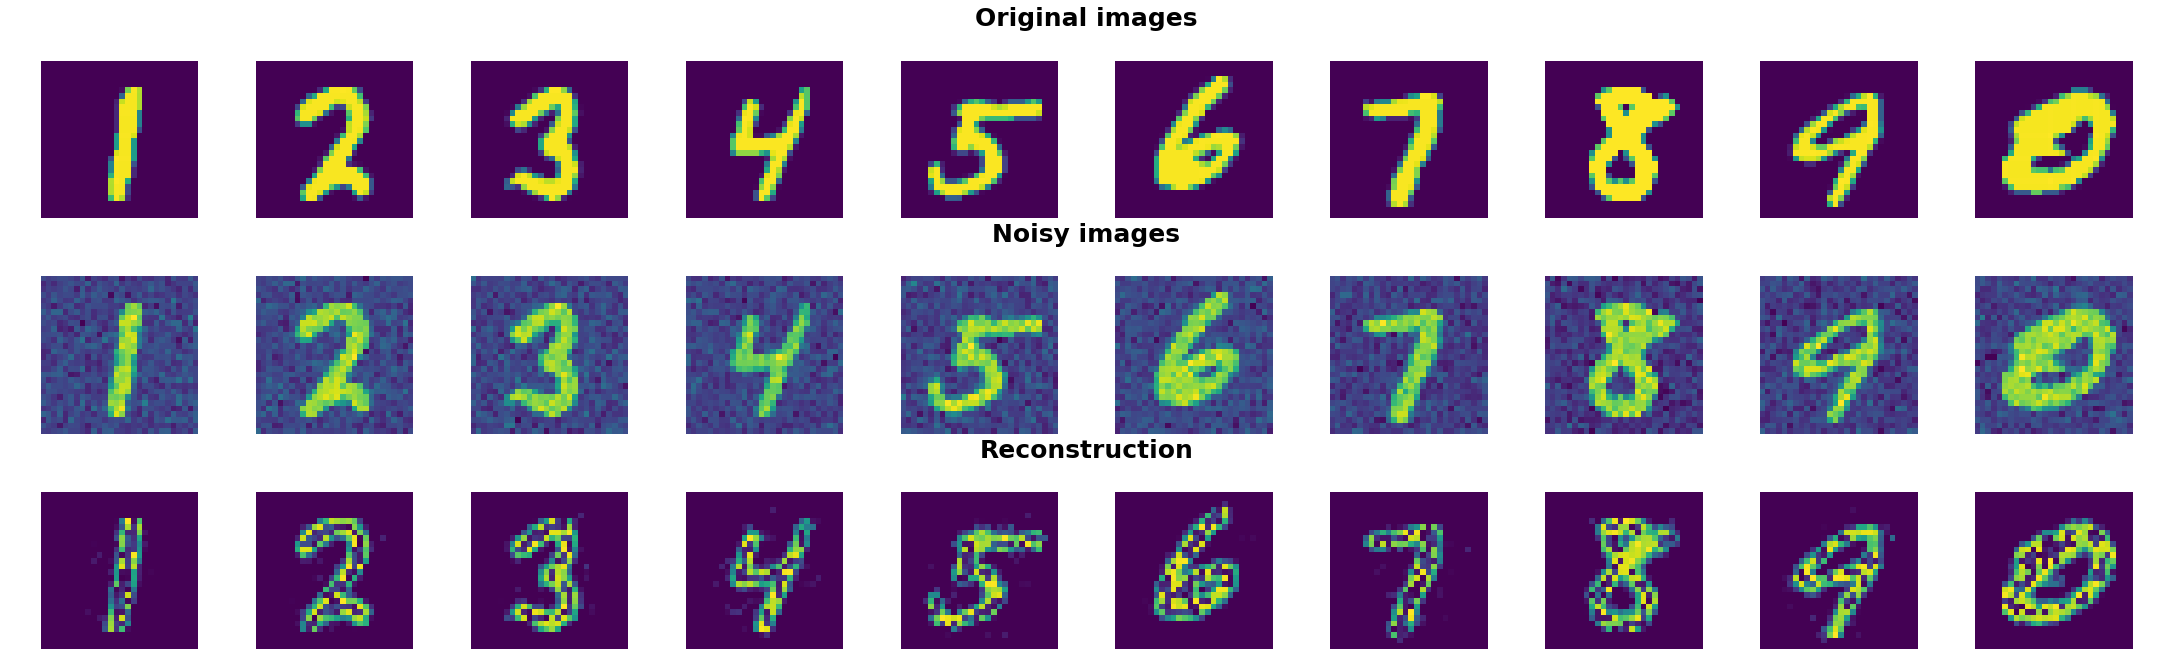

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
  OLD_EPOCHS
except NameError:
  EPOCHS = 50
  OLD_EPOCHS = 100

# If it is a new execution new results will be loaded here
reconstruction = torch.load(os.path.join(basepath, f'results2/in784_out400_epochs{OLD_EPOCHS}/outputs.pt'), map_location=DEVICE) 
image = torch.load(os.path.join(basepath, f'results2/in784_out400_epochs{OLD_EPOCHS}/original.pt'), map_location=DEVICE)
noise = torch.load(os.path.join(basepath, f'results2/in784_out400_epochs{OLD_EPOCHS}/noisy.pt'), map_location=DEVICE)

# Bring back to original size
reconstruction = reconstruction * 255
image = image * 255
noise = noise * 255

num_images = reconstruction.shape[0] - 6

fig, axes = plt.subplots(3, num_images, sharex=True, sharey=True, figsize=(30, 9))
fig.subplots_adjust(top=0.8)     

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=25, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

for i in range(num_images):
  axes[0][i].imshow(image[i,:,:].cpu().detach().type(torch.uint8))

  axes[1][i].imshow(noise[i,:,:].cpu().detach())

  axes[2][i].imshow(reconstruction[i,:,:].cpu().detach().type(torch.uint8))

for i in range(3):
  for j in range(num_images):
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])

grid = plt.GridSpec(3, 1)

create_subtitle(fig, grid[0, ::], 'Original images')
create_subtitle(fig, grid[1, ::], 'Noisy images')
create_subtitle(fig, grid[2, ::], 'Reconstruction')

fig.tight_layout(pad=.1)

As we can see, a single layer autoencoder is able to reconstruct the image partially, showing "holes" w.r.t. the original image

### Visualization nofinetuning

Now we look at the images generated by the assembled model without finetuning the weights

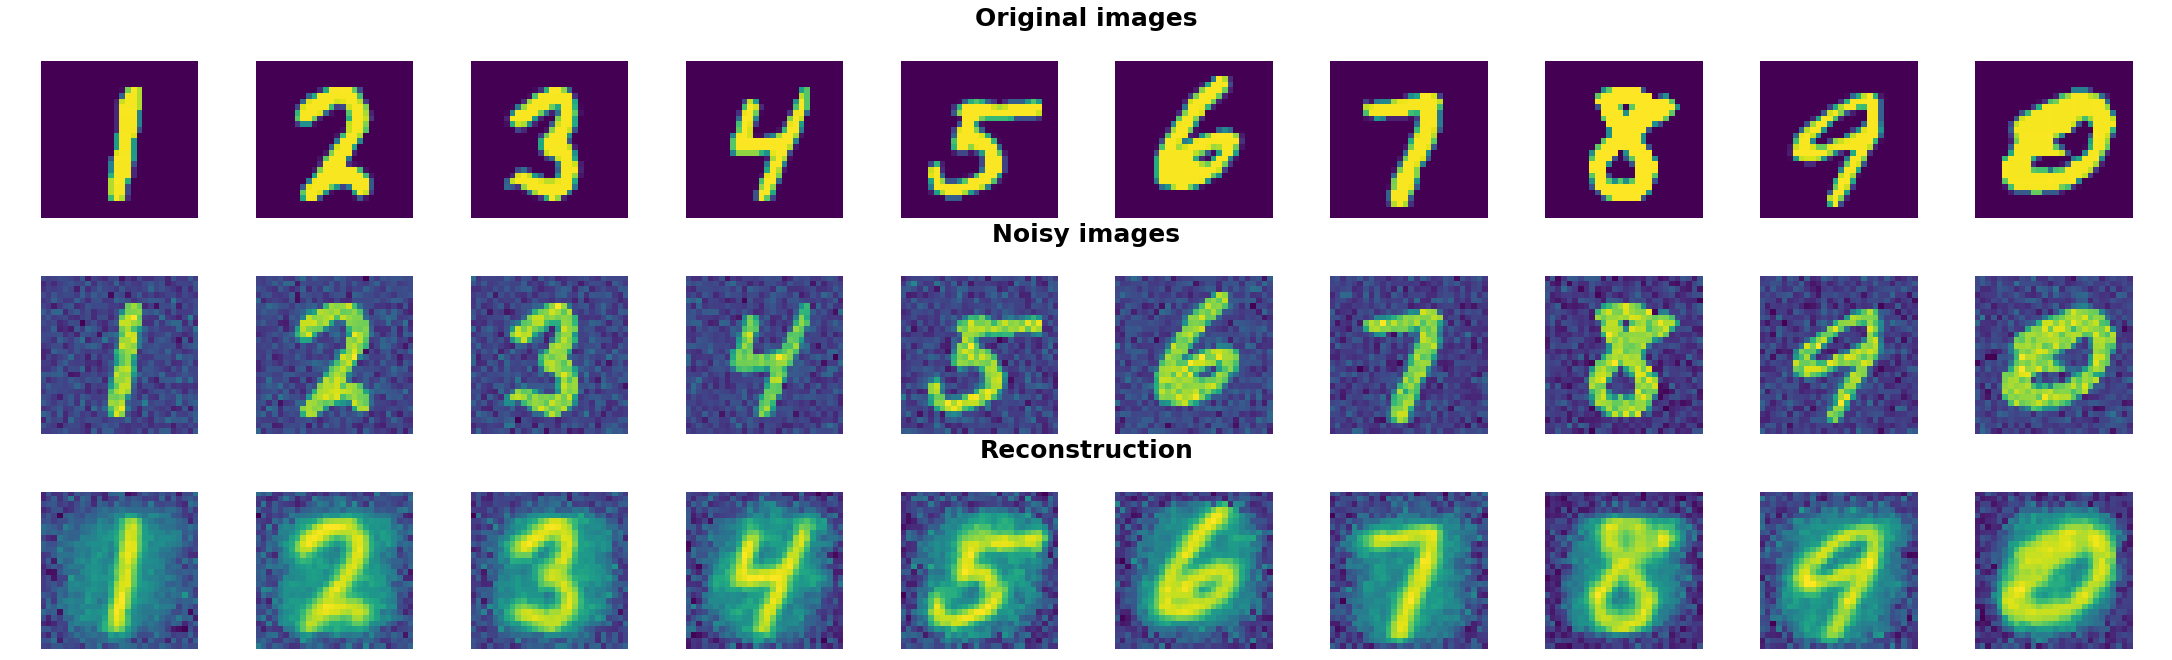

In [22]:
reconstruction = torch.load(os.path.join(basepath, f'results2/in784_outnofinetune_epochs{EPOCHS}/outputs.pt'), map_location=DEVICE) 
image = torch.load(os.path.join(basepath, f'results2/in784_outnofinetune_epochs{EPOCHS}/original.pt'), map_location=DEVICE)
noise = torch.load(os.path.join(basepath, f'results2/in784_outnofinetune_epochs{EPOCHS}/noisy.pt'), map_location=DEVICE)

# Bring back to original size
reconstruction = reconstruction * 255
image = image * 255
noise = noise * 255

num_images = reconstruction.shape[0] - 6

fig, axes = plt.subplots(3, num_images, sharex=True, sharey=True, figsize=(30, 9))
fig.subplots_adjust(top=0.8)     

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=25, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

for i in range(num_images):
  axes[0][i].imshow(image[i,:,:].cpu().detach().type(torch.uint8))

  axes[1][i].imshow(noise[i,:,:].cpu().detach())

  axes[2][i].imshow(reconstruction[i,:,:].cpu().detach().type(torch.uint8))

for i in range(3):
  for j in range(num_images):
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])

grid = plt.GridSpec(3, 1)

create_subtitle(fig, grid[0, ::], 'Original images')
create_subtitle(fig, grid[1, ::], 'Noisy images')
create_subtitle(fig, grid[2, ::], 'Reconstruction')

fig.tight_layout(pad=.1)

Putting together the different pretrained layers without finetuning the entire network, show us a nice reproducibility of the original images but perturbed with a lot of noise in particular in the area where the digits lie.

### Visualization finetuning

These instead are the representation of the assembled model with the finetuning of the weights

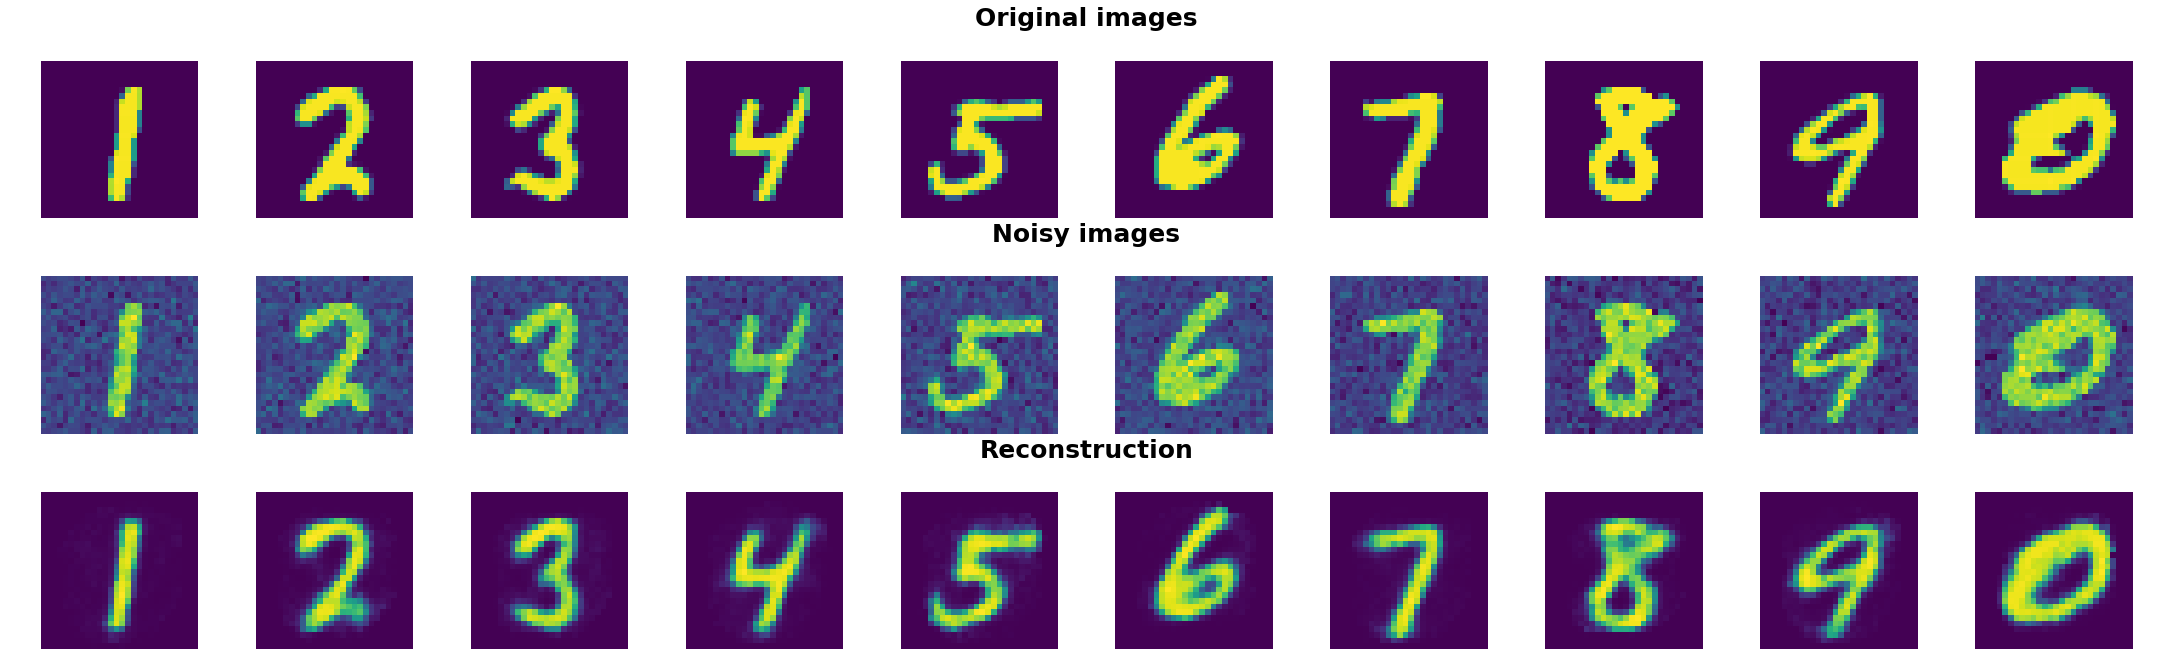

In [23]:
reconstruction = torch.load(os.path.join(basepath, f'results2/in784_outfinetuning_epochs{EPOCHS}/outputs.pt'), map_location=DEVICE) 
image = torch.load(os.path.join(basepath, f'results2/in784_outfinetuning_epochs{EPOCHS}/original.pt'), map_location=DEVICE)
noise = torch.load(os.path.join(basepath, f'results2/in784_outfinetuning_epochs{EPOCHS}/noisy.pt'), map_location=DEVICE)

# Bring back to original size
reconstruction = reconstruction * 255
image = image * 255
noise = noise * 255

num_images = reconstruction.shape[0] - 6

fig, axes = plt.subplots(3, num_images, sharex=True, sharey=True, figsize=(30, 9))
fig.subplots_adjust(top=0.8)     

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=25, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

for i in range(num_images):
  axes[0][i].imshow(image[i,:,:].cpu().detach().type(torch.uint8))

  axes[1][i].imshow(noise[i,:,:].cpu().detach())

  axes[2][i].imshow(reconstruction[i,:,:].cpu().detach().type(torch.uint8))

for i in range(3):
  for j in range(num_images):
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])

grid = plt.GridSpec(3, 1)

create_subtitle(fig, grid[0, ::], 'Original images')
create_subtitle(fig, grid[1, ::], 'Noisy images')
create_subtitle(fig, grid[2, ::], 'Reconstruction')

fig.tight_layout(pad=.1)

After the finetuning phase, we can see that our deep autoencoder is able to reconstruct correctly the original images eluding the noise present in the input image

### Loss comparison

Below we can see the loss comparison between the different models

Text(0.5, 1.0, '50 Epochs finetuning')

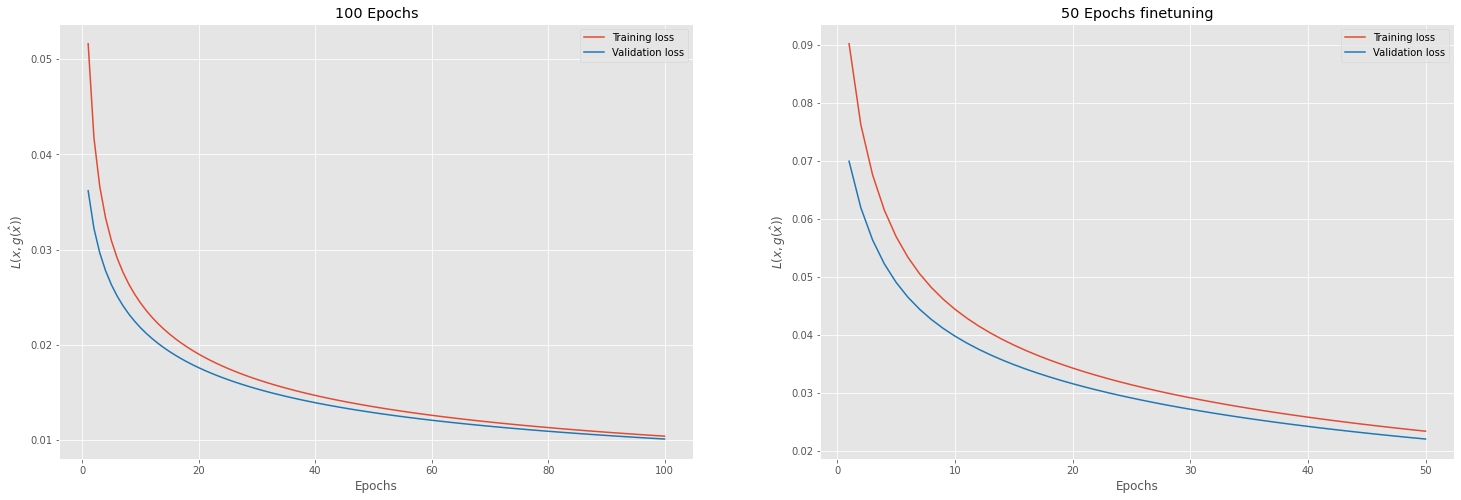

In [26]:
with open(os.path.join(basepath, f'results2/in784_out400_epochs{OLD_EPOCHS}/train.pickle'), 'rb') as handle:
  train_losses_single = pkl.load(handle)

with open(os.path.join(basepath, f'results2/in784_out400_epochs{OLD_EPOCHS}/valid.pickle'), 'rb') as handle:
  valid_losses_single = pkl.load(handle)

with open(os.path.join(basepath, f'results2/in784_outfinetuning_epochs{EPOCHS}/train.pickle'), 'rb') as handle:
  train_losses_finetune = pkl.load(handle)

with open(os.path.join(basepath, f'results2/in784_outfinetuning_epochs{EPOCHS}/valid.pickle'), 'rb') as handle:
  valid_losses_finetune = pkl.load(handle)


fig, axes = plt.subplots(1, 2, figsize=(25, 8))

epochs_single = list(train_losses_single.keys())
losses_train_single = list(train_losses_single.values())
losses_valid_single = list(valid_losses_single.values())

epochs_finetune = list(train_losses_finetune.keys())
losses_train_finetune = list(train_losses_finetune.values())
losses_valid_finetune = list(valid_losses_finetune.values())

axes[0].plot(epochs_single, losses_train_single, label="Training loss")
axes[0].plot(epochs_single, losses_valid_single, c='#1f77b4', label="Validation loss")
axes[1].plot(epochs_finetune, losses_train_finetune, label="Training loss")
axes[1].plot(epochs_finetune, losses_valid_finetune, c='#1f77b4', label="Validation loss")

for i in range(2):
  axes[i].set_xlabel("Epochs")
  axes[i].set_ylabel(r"$L(x,g(\hat{x}))$")
  axes[i].legend()

axes[0].set_title(f"{OLD_EPOCHS} Epochs")
axes[1].set_title(f"{EPOCHS} Epochs finetuning")

## Latent space interpolation

Now we are going to look at what happens if we take two latent space representation, respectively $z_1$ and $z_2$, in two different settings:
- $z_1$ and $z_2$ belongs to the same class
- $z_1$ and $z_2$ belongs to different classes

We generate the according latent representation by passing them through the encoder

\begin{align*}
  z_1 = E(\hat{x_1}) \\
  z_2 = E(\hat{x_2})
\end{align*}

We take a convex combination of this two representation as

\begin{align*}
  z = \alpha * z_1 + (1 - \alpha) * z_2
\end{align*}

with $\alpha \in [0,1]$, and reconstruct the according image by passing $z$ through the decoder $\tilde{x} = D(z)$

We restore the original dataset and we show 10 random images from it

In [27]:
tr_images = tr_images_copy
ts_images = ts_images_copy
noisy_tr_images = noisy_tr_images_copy
noisy_ts_images = noisy_ts_images_copy

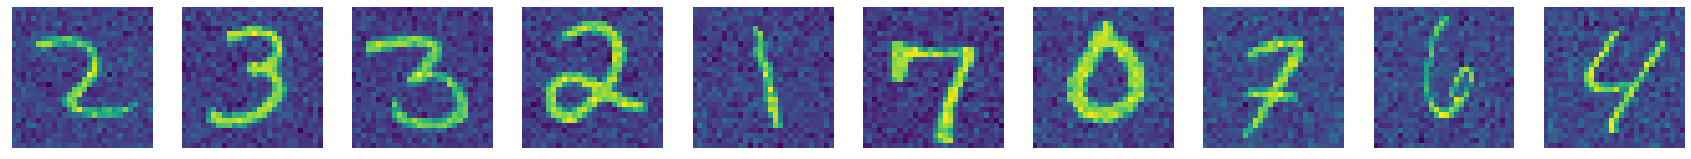

In [28]:
mid = int(len(noisy_ts_images) / 4)

fig, axes = plt.subplots(1, 10, figsize=(30,10))

for i in range(mid, mid+10):
  axes[i-mid].imshow((noisy_ts_images[i] * 255))
  axes[i-mid].set_xticks([])
  axes[i-mid].set_yticks([])

From above we can choose directly the first three images, being them two digit $7$ and one digit $2$

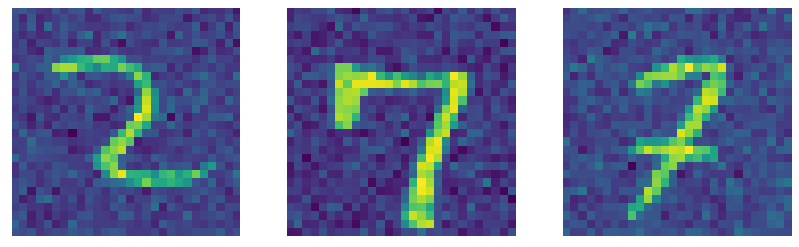

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(14,8))

indexes = [mid, mid+5, mid+7]

for i, val in enumerate(indexes):
  axes[i].imshow((noisy_ts_images[val] * 255))
  axes[i].set_xticks([])
  axes[i].set_yticks([])

We load all the different models from the pretrained weights without the need of performing again the training

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

singlelayer = DAE(784, 400, "output", 32)

singlelayer.load_state_dict( torch.load(os.path.join(basepath, f"weights2/in784_out400_epochs{OLD_EPOCHS}/model_weights.pth"), map_location=DEVICE) )

weights_784 = torch.load(os.path.join(basepath, f"weights2/in784_out400_epochs{OLD_EPOCHS}/model_weights.pth"), map_location=DEVICE)["weights"]

weights_400 = torch.load(os.path.join(basepath, f"weights2/in400_out200_epochs{OLD_EPOCHS}/model_weights.pth"), map_location=DEVICE)["weights"]

layerwisepretrained = DeepDAE(784, [400, 200], "", 32, weights_784, weights_400)

weights_finetuning = torch.load(os.path.join(basepath, f"weights2/in784_outfinetuning_epochs{EPOCHS}/model_weights.pth"), map_location=DEVICE)

finetunedmodel = DeepDAE(784, [400, 200], "", 32, weights_finetuning["w1"], weights_finetuning["w2"])

### Comparison

We look at the convex combination using the three different models: single layer, layerwise pretrained and finetuned

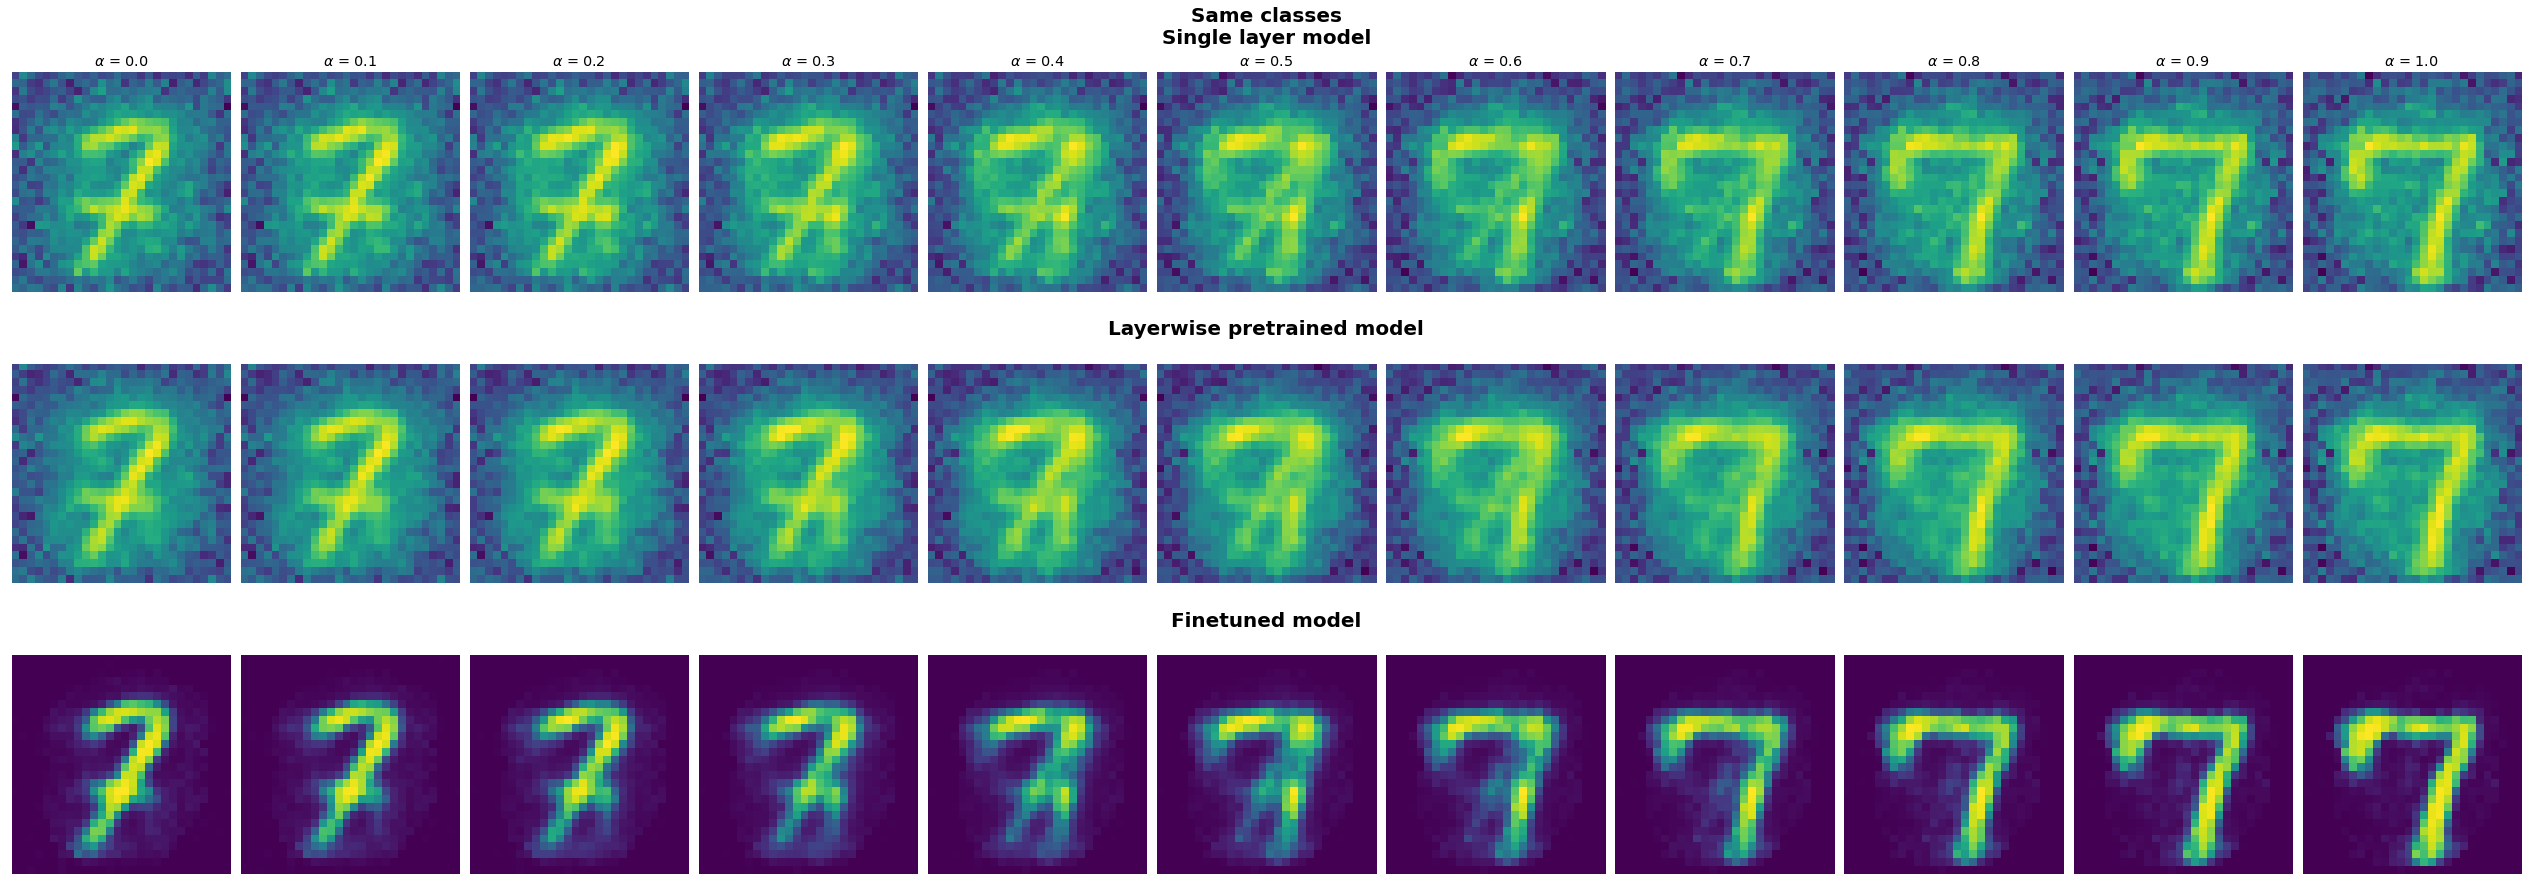

In [67]:
singlelayer.eval()
layerwisepretrained.eval()
finetunedmodel.eval()

singlelayer.to(DEVICE)
layerwisepretrained.to(DEVICE)
finetunedmodel.to(DEVICE)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=20, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

WIDTH, HEIGHT = 28, 28

alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

reconstructions_singlemodel = []
reconstructions_pretrained = []
reconstructions_finetuned = []

with torch.no_grad():
  for alpha in alpha_values: 

    input_1 = torch.reshape(noisy_ts_images[mid+5], (1, WIDTH, HEIGHT)).to(DEVICE)
    input_2 = torch.reshape(noisy_ts_images[mid+7], (1, WIDTH, HEIGHT)).to(DEVICE)

    reconstruction, z = singlelayer.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_singlemodel.append(reconstruction)

    reconstruction, z = layerwisepretrained.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_pretrained.append(reconstruction)

    reconstruction, z = finetunedmodel.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_finetuned.append(reconstruction)  

fig, axes = plt.subplots(3, len(alpha_values), figsize=(35,12))

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_singlemodel, alpha_values)):
  axes[0][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  axes[0][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[0][i].set_xticks([])
  axes[0][i].set_yticks([])

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_pretrained, alpha_values)):
  axes[1][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  # axes[1][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[1][i].set_xticks([])
  axes[1][i].set_yticks([])

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_finetuned, alpha_values)):
  axes[2][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  # axes[1][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[2][i].set_xticks([])
  axes[2][i].set_yticks([])

grid = plt.GridSpec(3, len(alpha_values))

create_subtitle(fig, grid[0, ::], 'Same classes\nSingle layer model')
create_subtitle(fig, grid[1, ::], '\n\n\nLayerwise pretrained model')
create_subtitle(fig, grid[2, ::], '\nFinetuned model')

fig.tight_layout(pad=1e-10)

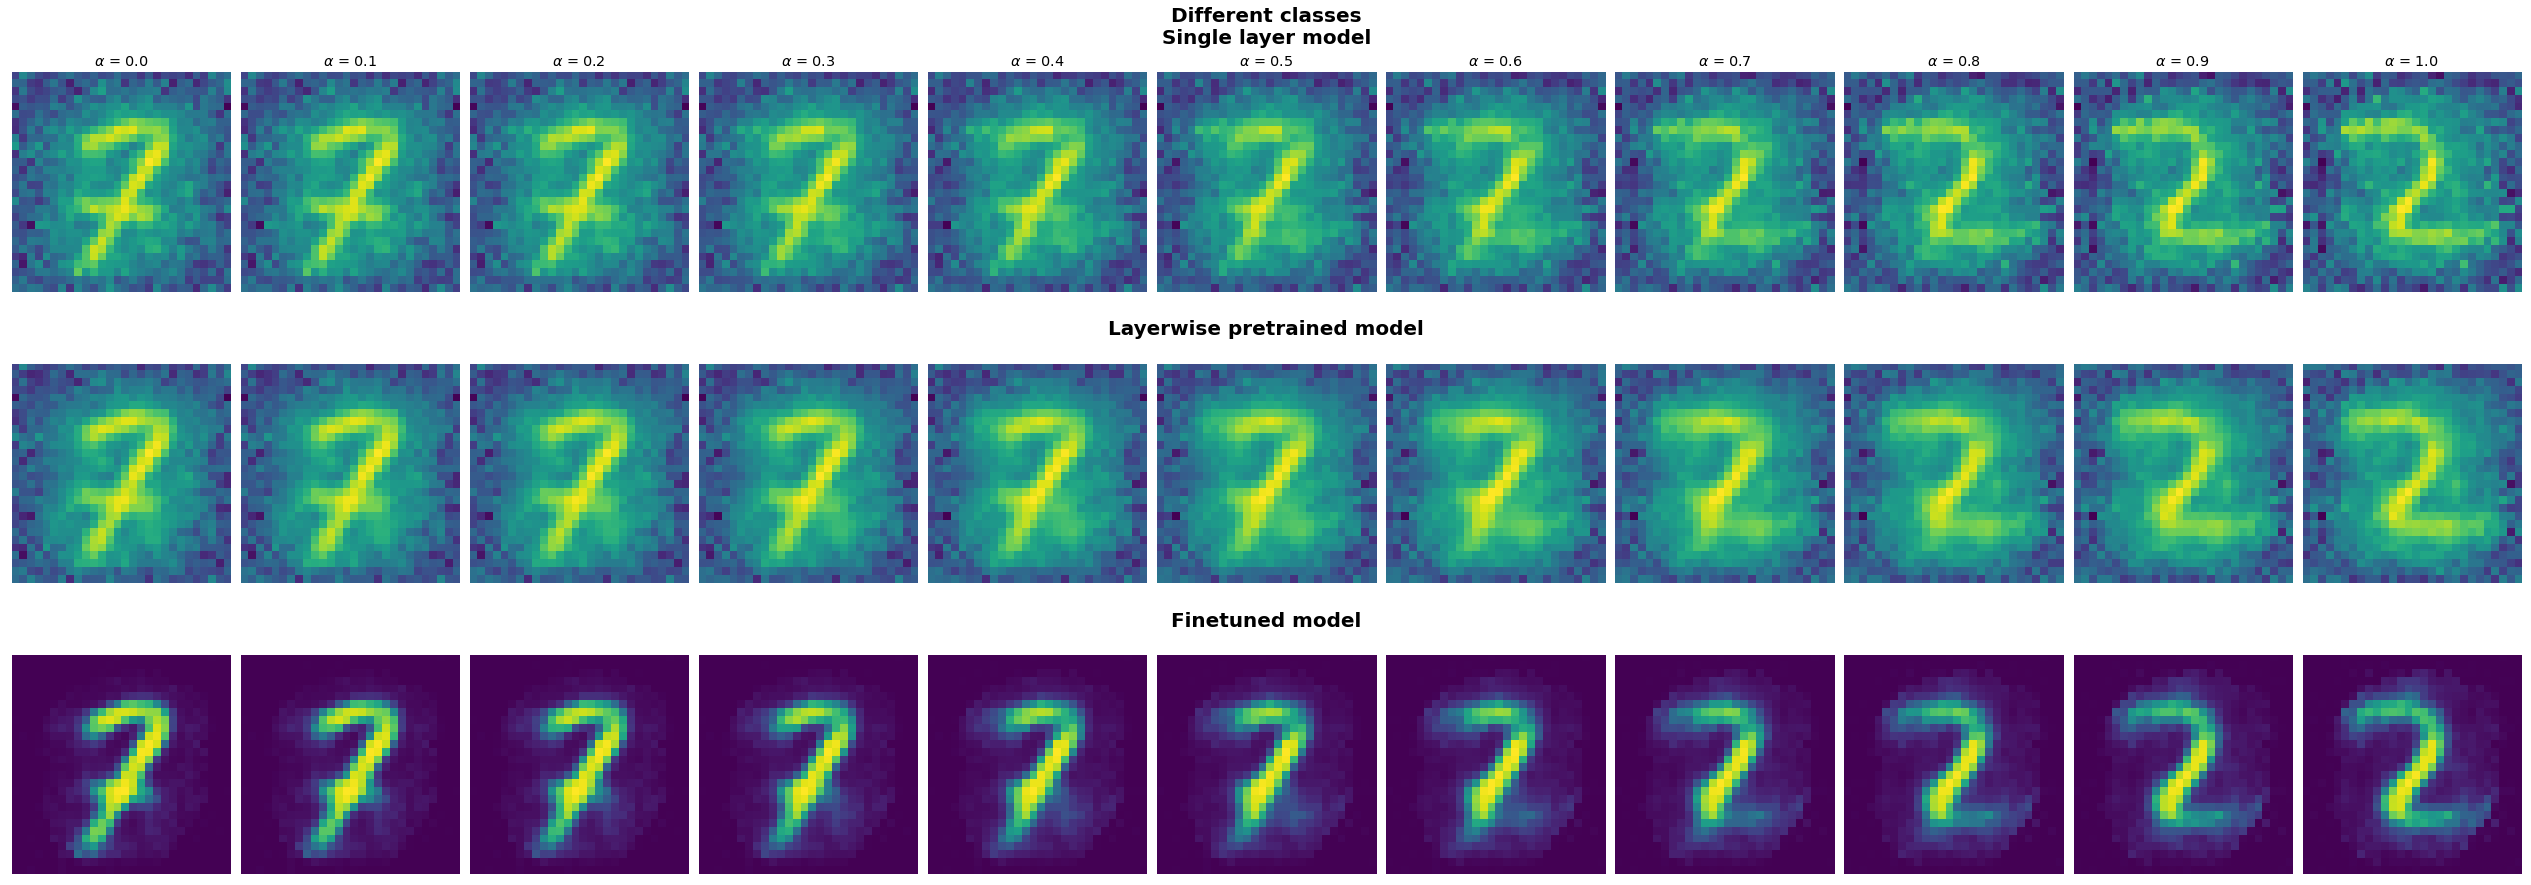

In [68]:
singlelayer.eval()
layerwisepretrained.eval()
finetunedmodel.eval()

singlelayer.to(DEVICE)
layerwisepretrained.to(DEVICE)
finetunedmodel.to(DEVICE)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=20, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

WIDTH, HEIGHT = 28, 28

alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

reconstructions_diff_singlemodel = []
reconstructions_diff_pretrained = []
reconstructions_diff_finetuned = []

with torch.no_grad():
  for alpha in alpha_values: 

    input_1 = torch.reshape(noisy_ts_images[mid], (1, WIDTH, HEIGHT)).to(DEVICE)
    input_2 = torch.reshape(noisy_ts_images[mid+7], (1, WIDTH, HEIGHT)).to(DEVICE)

    reconstruction, z = singlelayer.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_diff_singlemodel.append(reconstruction)

    reconstruction, z = layerwisepretrained.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_diff_pretrained.append(reconstruction)

    reconstruction, z = finetunedmodel.latent_space_interpolation(input_1, input_2, alpha)
    reconstruction = reconstruction * 255
    reconstructions_diff_finetuned.append(reconstruction)  

fig, axes = plt.subplots(3, len(alpha_values), figsize=(35,12))

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_diff_singlemodel, alpha_values)):
  axes[0][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  axes[0][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[0][i].set_xticks([])
  axes[0][i].set_yticks([])

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_diff_pretrained, alpha_values)):
  axes[1][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  # axes[2][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[1][i].set_xticks([])
  axes[1][i].set_yticks([])

for i, (reconstruction, alpha) in enumerate(zip(reconstructions_diff_finetuned, alpha_values)):
  axes[2][i].imshow(reconstruction[0,:,:].cpu().detach().type(torch.uint8))
  # axes[1][i].set_title(r"$\alpha$ = " + str(alpha))
  axes[2][i].set_xticks([])
  axes[2][i].set_yticks([])


grid = plt.GridSpec(3, len(alpha_values))

create_subtitle(fig, grid[0, ::], 'Different classes\nSingle layer model')
create_subtitle(fig, grid[1, ::], '\n\n\nLayerwise pretrained model')
create_subtitle(fig, grid[2, ::], '\nFinetuned model')

fig.tight_layout(pad=1e-10)

As we can see, the single layer model and the layerwise pretrained model still suffer from noise in their images, while the finetuned model is capable of removing the noise from the reconstruction.

Still, every model seems to reconstruct the interpolation quite well, by showing a transition from one image to the other by changing the value of $\alpha$.
 
It is possible to distinguish what are the digits and the trasition from one $7$ to the other and from $7$ to $2$ in every model.

## Data Manifold reconstruction

The AE asssumption states that the autoencoder learn the data representation in a smaller manifold space. We can verify this by applying a continuous feeding of our autoencoder starting from a random image $x$, and continuously feeding the output to the model

\begin{align*}
  D(x) - x \propto \frac{\partial \log{p(x)}}{\partial x}
\end{align*}

tensor(-3.2726)
tensor(2.4329)


([], <a list of 0 Text major ticklabel objects>)

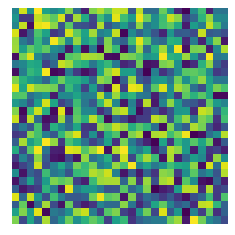

In [69]:
random_noise_image = torch.randn((1, 28, 28))

minimum = random_noise_image.min()
maximum = random_noise_image.max()

print(minimum)
print(maximum)

plt.imshow((random_noise_image[0,:,:]*255).type(torch.uint8), cmap=plt.cm.viridis)

plt.xticks([])
plt.yticks([])

Only few iterations of gradient ascent are needed

In [70]:
singlelayer.eval()
layerwisepretrained.eval()
finetunedmodel.eval()

iterations = 50

gradient_ascent = []

singlelayer_images = []
layerwise_images = []
finetuned_images = []

input = random_noise_image

input = input.to(DEVICE)

with torch.no_grad():
  for i in tqdm(range(iterations)):
    output, z = singlelayer(input)

    loss = singlelayer.loss(input, output)
    gradient_ascent.append(loss.item())

    input = output

    if i%2==0:
      singlelayer_images.append(output)

input = random_noise_image

input = input.to(DEVICE)

with torch.no_grad():
  for i in tqdm(range(iterations)):
    output, z = layerwisepretrained(input)

    loss = layerwisepretrained.loss(input, output)
    gradient_ascent.append(loss.item())

    input = output

    if i%2==0:    
      layerwise_images.append(output)

input = random_noise_image

input = input.to(DEVICE)

with torch.no_grad():
  for i in tqdm(range(iterations)):
    output, z = finetunedmodel(input)

    loss = finetunedmodel.loss(input, output)
    gradient_ascent.append(loss.item())

    input = output

    if i%2==0:
      finetuned_images.append(output)

100%|██████████| 50/50 [00:00<00:00, 4355.91it/s]


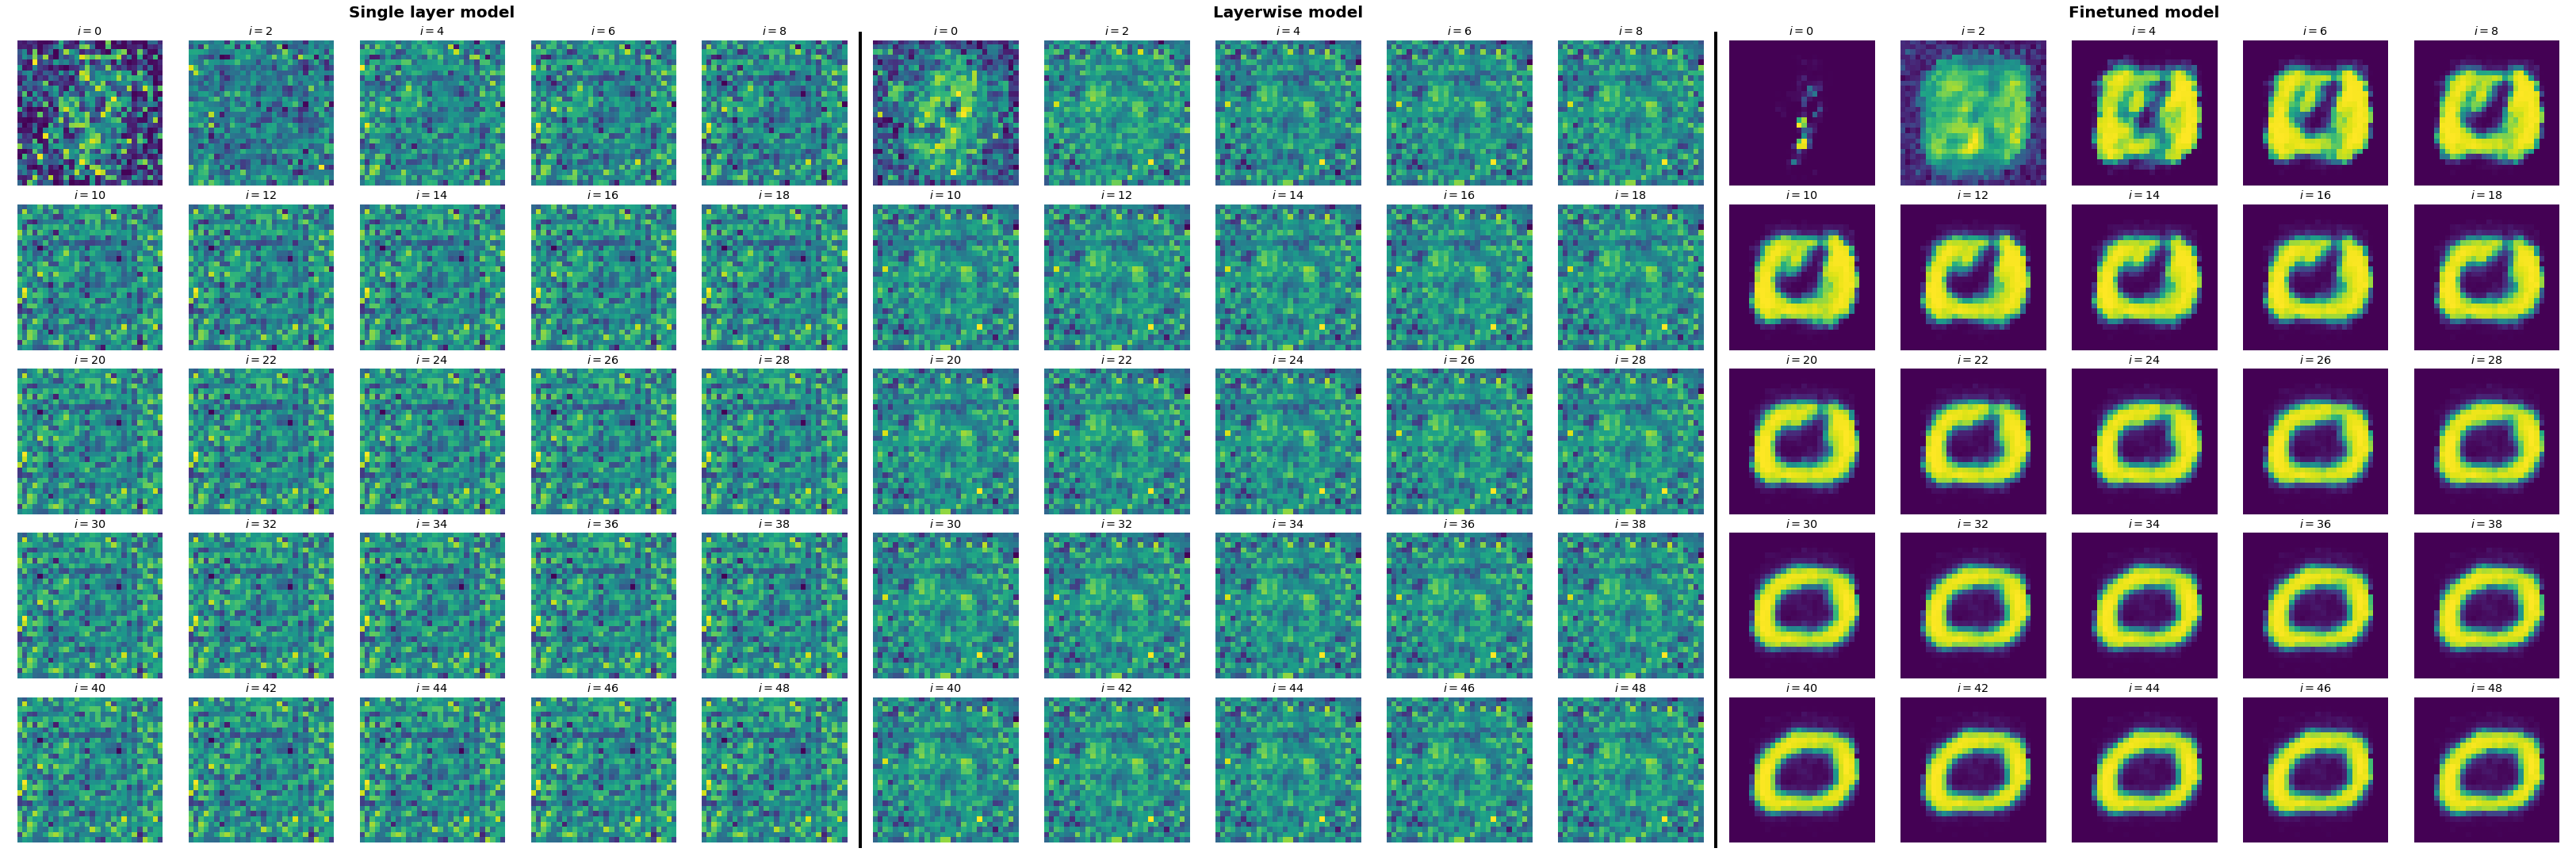

In [71]:
num = int(len(layerwise_images)/5)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
  "Sign sets of subplots with title"
  row = fig.add_subplot(grid)
  # the '\n' is important
  row.set_title(f'{title}\n', fontsize=20, fontweight='semibold')
  # hide subplot
  row.set_frame_on(False)
  row.axis('off')

fig, axes = plt.subplots( num, num*3, figsize=(45, 15))

index = 0
for i in range(num):
  for j in range(num):
    axes[i][j].imshow((singlelayer_images[index][0,:,:]*255).cpu().detach(), cmap = plt.cm.viridis)
    axes[i][j].set_title(r"$i = $" + f"{(index)*2}")
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])
    index += 1

index = 0
for i in range(num):
  for j in range(num):
    axes[i][j+num].imshow((layerwise_images[index][0,:,:]*255).cpu().detach(), cmap = plt.cm.viridis)
    axes[i][j+num].set_title(r"$i = $" + f"{(index)*2}")
    axes[i][j+num].set_xticks([])
    axes[i][j+num].set_yticks([])
    index += 1

index = 0
for i in range(num):
  for j in range(num):
    axes[i][j+num*2].imshow((finetuned_images[index][0,:,:]*255).cpu().detach(), cmap = plt.cm.viridis)
    axes[i][j+num*2].set_title(r"$i = $" + f"{(index)*2}")
    axes[i][j+num*2].set_xticks([])
    axes[i][j+num*2].set_yticks([])
    index += 1

grid = plt.GridSpec(num, num*3)

create_subtitle(fig, grid[::, 0:num], 'Single layer model')
create_subtitle(fig, grid[::, num:num*2], 'Layerwise model')
create_subtitle(fig, grid[::, num*2:num*3], 'Finetuned model')

line = plt.Line2D((.334,.334),(.0,.95), color="k", linewidth=4)
fig.add_artist(line)

line = plt.Line2D((.667,.667),(.0,.95), color="k", linewidth=4)
fig.add_artist(line)

fig.tight_layout(pad=0.1)

From below we can see completely different behaviors.    
The single layer model and stacked layerwise pretrained model reconstruct from a random noise a structure similar to the original noise, maybe the number of epochs where not enough to make the autoencoder capable of learning the underlying manifold structure.  
Instead for the finetuned model, we see that in the first iterations it shows a blob of noise located in the center where all the digits lie, and after more iterations is able to completely remove the noise and create the representation of a $0$.

## T-SNE projection

Lastly, we show the T-SNE projection of the latent space embeddings

In [72]:
from sklearn.manifold import TSNE
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 3.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.334008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.091736
[t-SNE] KL divergence after 1000 iterations: 1.729919


(-100.5189655303955, 95.0645206451416, -90.37654571533203, 91.77731781005859)

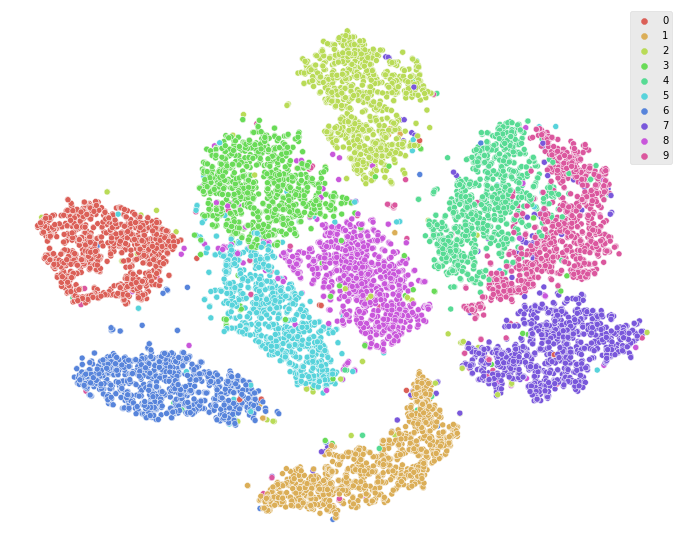

In [74]:
finetunedmodel.to(DEVICE)

encodings = []

with torch.no_grad():
  # Pass all the validation images and store the encoding
  for noisy_ts_img in noisy_ts_images:

    noisy_ts_img = noisy_ts_img.to(DEVICE)

    _, noisy_z = finetunedmodel(torch.reshape(noisy_ts_img, (1, ) + noisy_ts_img.shape))

    encodings.append(noisy_z)

  new_noisy_ts_images = torch.stack((encodings))

embeddings = TSNE(n_components=2, verbose=1).fit_transform(torch.flatten(new_noisy_ts_images.cpu(),1))
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings[:, 0], y=embeddings[:, 1],
    hue=ts_labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
)
plt.tight_layout()
plt.axis('off')
